In [132]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from hyperopt import fmin, tpe, hp, STATUS_OK

#Current winner: catboost_classifier = CatBoostClassifier() # No Feature Engineering

In [133]:
train = pd.read_csv('data/train_final.csv', index_col = "Id")
test = pd.read_csv('data/test_final.csv', index_col = "Id")
#col 84 and 86 is float64, rest are int64
#col 0 is Id, col 1 is Y
#test has more rows than train
#col 2 and 3 have -999
#34, 39 are all zero in train

X, y = train.drop('Y', axis=1), train['Y']
test.describe()

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86
count,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.0,3854.000000,3854.000000,3854.000000,3854.000000,3854.0,3854.0,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000,3854.000000
mean,-0.497924,-3.262065,0.004930,0.425791,0.031136,0.002335,0.034510,0.030358,0.007265,0.016866,0.000259,0.210171,0.410742,0.042034,0.452517,0.009600,0.011417,0.901920,0.520498,0.090815,0.621432,0.006227,0.000778,0.013492,0.148158,0.621432,0.054229,0.279969,0.033991,0.012974,0.792423,0.0,0.000259,0.006487,0.052413,0.015828,0.0,0.0,0.316035,0.270109,0.760509,0.022833,0.005189,0.026466,0.368708,0.026725,0.009341,0.014530,0.003114,0.917488,0.955371,0.466788,0.016606,0.031655,0.005189,0.063830,0.005189,0.958225,0.346653,0.060976,0.044629,0.002335,0.955631,0.716917,0.234821,0.073690,0.035029,0.999481,0.012195,0.001297,0.052154,0.000778,0.205241,0.047483,0.416710,0.021536,0.194084,0.072133,0.004930,0.000259,0.044629,1.050337,4210.574468,0.035547,0.242727
std,22.755459,57.937152,0.070049,0.494527,0.173709,0.048274,0.182558,0.171593,0.084937,0.128785,0.016108,0.407483,0.492032,0.200693,0.497805,0.097523,0.106251,0.297461,0.499644,0.287383,0.485093,0.078677,0.027893,0.115386,0.355302,0.485093,0.226499,0.449042,0.181229,0.113175,0.405624,0.0,0.016108,0.080289,0.222887,0.124825,0.0,0.0,0.464987,0.444074,0.426828,0.149392,0.071860,0.160537,0.482517,0.161301,0.096209,0.119678,0.055720,0.275178,0.206515,0.498960,0.127807,0.175104,0.071860,0.244481,0.071860,0.200100,0.475966,0.239317,0.206515,0.048274,0.205941,0.450555,0.423942,0.261299,0.183876,0.022777,0.109770,0.036000,0.222366,0.027893,0.403930,0.212697,0.493078,0.145182,0.395545,0.258741,0.070049,0.016108,0.206515,0.290982,2429.397979,0.232417,1.892194
min,-999.000000,-999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-3.000000,0.000000,-6.523543
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.0

In [134]:
# Preprocessing

# Replace -999 with mean
X = X.replace(-999, np.nan)
test = test.replace(-999, np.nan)
X = X.fillna(X.mean())
test = test.fillna(test.mean())

# Remove constant columns
# colsToRemove = []
# for col in X.columns:
#     if X[col].std() == 0: 
#         colsToRemove.append(col)
# print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))
# print(colsToRemove)
# X.drop(colsToRemove, axis=1, inplace=True)
# test.drop(colsToRemove, axis=1, inplace=True)
        
# Identify continuous features for scaling
# continuous_features = ['84', '86']
# continuous_features = ['84', '85', '86']

# Scale continuous features
# scaler = StandardScaler()
# train[continuous_features] = scaler.fit_transform(train[continuous_features])
# test[continuous_features] = scaler.transform(test[continuous_features])

# Remove duplicate columns
# def duplicate_columns(frame):
#     groups = frame.columns.to_series().groupby(frame.dtypes).groups
#     dups = []

#     for t, v in groups.items():

#         cs = frame[v].columns
#         vs = frame[v]
#         lcs = len(cs)

#         for i in range(lcs):
#             ia = vs.iloc[:,i].values
#             for j in range(i+1, lcs):
#                 ja = vs.iloc[:,j].values
#                 if np.array_equal(ia, ja):
#                     dups.append(cs[i])
#                     break

#     return dups
# colsToRemove = duplicate_columns(X)
# print(duplicate_columns(X))
# print(duplicate_columns(test))
# X.drop(colsToRemove, axis=1, inplace=True)
# test.drop(colsToRemove, axis=1, inplace=True)

# Drop sparse columns

# Print X row 6 last column
# print(X.iloc[6, -1])
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X.shape, y.shape, test.shape

((2853, 85), (2853,), (3854, 85))

In [64]:
import lightgbm as lgb

def run_lgb(train_X, train_y, val_X, val_y, test_X):

    params = {
        "objective" : "binary",
        "metric" : "auc",
        "num_leaves" : 30,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }

    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, valid_sets=[lgval])
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

pred_test, model, evals_result = run_lgb(X_train, y_train, X_test, y_test, test)

[LightGBM] [Fatal] The number of features in data (79) is not the same as it was in training data (78).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.


LightGBMError: The number of features in data (79) is not the same as it was in training data (78).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [ ]:
# feature importance
print("Features Importance...")
gain = model.feature_importance('gain')
featureimp = pd.DataFrame({'feature':model.feature_name(), 
                   'split':model.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(featureimp[:50])

In [6]:
import lightgbm as lgb

params = {'num_leaves': 7,
 'feature_fraction': 0.901963034946511,
 'bagging_fraction': 0.8822860971145076,
 'bagging_freq': 1,
 'min_child_samples': 27}


lgb_classifier = lgb.LGBMClassifier(**params)

lgb_cv_scores = cross_val_score(lgb_classifier, X, y, cv=5, scoring='roc_auc')

lgb_cv_scores_mean = lgb_cv_scores.mean()
lgb_cv_scores_std = lgb_cv_scores.std()

lgb_cv_scores_mean, lgb_cv_scores_std


[LightGBM] [Warning] feature_fraction is set=0.901963034946511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.901963034946511
[LightGBM] [Warning] bagging_fraction is set=0.8822860971145076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8822860971145076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.901963034946511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.901963034946511
[LightGBM] [Warning] bagging_fraction is set=0.8822860971145076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8822860971145076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 1001, number of negative: 1281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001662 seconds.
You can set `

(0.9036059382718348, 0.010293504646694962)

In [29]:
#lgbm with optuna
import optuna
from optuna.samplers import TPESampler

def objective(trial):

    #Train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.2, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.2, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 256),
    }

    lgb_classifier = lgb.LGBMClassifier(**params)
    lgb_classifier.fit(X_train, y_train)
    preds = lgb_classifier.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, preds)
    return auc
    
    

sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100)
study.best_params


[I 2023-10-07 15:36:50,184] A new study created in memory with name: no-name-4d246240-3f40-4130-b7e0-00a420a82824
[I 2023-10-07 15:36:50,285] Trial 0 finished with value: 0.8911852589641434 and parameters: {'num_leaves': 97, 'feature_fraction': 0.960571445127933, 'bagging_fraction': 0.7855951534491241, 'bagging_freq': 5, 'min_child_samples': 41}. Best is trial 0 with value: 0.8911852589641434.
[I 2023-10-07 15:36:50,337] Trial 1 finished with value: 0.8953685258964144 and parameters: {'num_leaves': 41, 'feature_fraction': 0.24646688973455957, 'bagging_fraction': 0.8929409166199482, 'bagging_freq': 5, 'min_child_samples': 182}. Best is trial 1 with value: 0.8953685258964144.
[I 2023-10-07 15:36:50,391] Trial 2 finished with value: 0.9046688247011954 and parameters: {'num_leaves': 7, 'feature_fraction': 0.9759278817295955, 'bagging_fraction': 0.8659541126403374, 'bagging_freq': 2, 'min_child_samples': 48}. Best is trial 2 with value: 0.9046688247011954.
[I 2023-10-07 15:36:50,458] Trial 

{'num_leaves': 7,
 'feature_fraction': 0.901963034946511,
 'bagging_fraction': 0.8822860971145076,
 'bagging_freq': 1,
 'min_child_samples': 27}

In [7]:
import xgboost as xgb

# Initialize XGBoost classifier
params = {'booster': 'dart',
 'lambda': 5.828408219529399e-06,
 'alpha': 5.269491488976981e-05,
 'max_depth': 1,
 'eta': 0.9832252365438633,
 'gamma': 0.002454293232690081,
 'grow_policy': 'depthwise',
 'sample_type': 'weighted',
 'normalize_type': 'tree',
 'rate_drop': 6.566486512923252e-07,
 'skip_drop': 0.011194275544821984}
xgb_classifier = xgb.XGBClassifier(**params)

# Evaluate model using cross-validation
xgb_cv_scores = cross_val_score(xgb_classifier, X, y, cv=5, scoring='roc_auc')

xgb_cv_scores_mean = xgb_cv_scores.mean()
xgb_cv_scores_std = xgb_cv_scores.std()

xgb_cv_scores_mean, xgb_cv_scores_std

(0.8981974685680953, 0.011021473758866729)

In [39]:
#xgboost with optuna
import optuna
from optuna.samplers import TPESampler

def objective(trial):

    #Train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    params = {
        'silent': 1,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
    }

    if params['booster'] == 'gbtree' or params['booster'] == 'dart':
        params['max_depth'] = trial.suggest_int('max_depth', 1, 9)
        params['eta'] = trial.suggest_loguniform('eta', 1e-8, 1.0)
        params['gamma'] = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        params['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    if params['booster'] == 'dart':
        params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        params['rate_drop'] = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
        params['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)

    xgb_classifier = XGBClassifier(**params)
    xgb_classifier.fit(X_train, y_train)
    preds = xgb_classifier.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, preds)
    return auc
    
sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20)
study.best_params

[I 2023-10-07 15:55:44,030] A new study created in memory with name: no-name-75c2febc-9cf4-4a9e-9cf6-c1acf096f1ce
[I 2023-10-07 15:55:44,258] Trial 0 finished with value: 0.8918326693227092 and parameters: {'booster': 'gblinear', 'lambda': 0.0006155564318973012, 'alpha': 1.77071686435378e-07}. Best is trial 0 with value: 0.8918326693227092.
[I 2023-10-07 15:55:47,520] Trial 1 finished with value: 0.9051855079681275 and parameters: {'booster': 'dart', 'lambda': 0.0006440507553993703, 'alpha': 0.004619347374377372, 'max_depth': 1, 'eta': 0.574485163632042, 'gamma': 0.04566054873446119, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.1371407316372935e-06, 'skip_drop': 0.000784915956255507}. Best is trial 1 with value: 0.9051855079681275.
[I 2023-10-07 15:55:50,961] Trial 2 finished with value: 0.8626556274900399 and parameters: {'booster': 'dart', 'lambda': 4.452048365748842e-05, 'alpha': 0.019116469627784252, 'max_depth': 2, 'eta': 0.000129

{'booster': 'dart',
 'lambda': 5.828408219529399e-06,
 'alpha': 5.269491488976981e-05,
 'max_depth': 1,
 'eta': 0.9832252365438633,
 'gamma': 0.002454293232690081,
 'grow_policy': 'depthwise',
 'sample_type': 'weighted',
 'normalize_type': 'tree',
 'rate_drop': 6.566486512923252e-07,
 'skip_drop': 0.011194275544821984}

In [55]:
from catboost import CatBoostClassifier
# cbc = CatBoostClassifier()
# grid = {'learning_rate' : [0.01,0.02,0.03,0.04],'iterations' : [10, 20,30,40,50,60,70,80,90, 100, 200, 300], 'depth' : [3, 4,5,6,7,8,9, 10]}
# gscv = GridSearchCV (estimator = cbc, param_grid = grid, scoring ='roc_auc', cv = 5)
# gscv.fit(X,y)
# Initialize CatBoost classifier
# catboost_classifier = CatBoostClassifier(iterations=100, random_state=42, verbose=False)
params = {'learning_rate': 0.038175556251476374,
 'depth': 3,
 'l2_leaf_reg': 5.1375243952496925,
 'boosting_type': 'Ordered',
 'max_ctr_complexity': 5}
catboost_classifier = CatBoostClassifier(**params)

# Evaluate model using cross-validation
catboost_cv_scores = cross_val_score(catboost_classifier, X, y, cv=5, scoring='roc_auc')

catboost_cv_scores_mean = catboost_cv_scores.mean()
catboost_cv_scores_std = catboost_cv_scores.std()


# gscv.best_score_, gscv.best_params_
# {'depth': 3, 'iterations': 300, 'learning_rate': 0.04}
catboost_cv_scores_mean, catboost_cv_scores_std

0:	learn: 0.6690168	total: 5.05ms	remaining: 5.04s
1:	learn: 0.6469885	total: 8.81ms	remaining: 4.39s
2:	learn: 0.6272522	total: 12.9ms	remaining: 4.28s
3:	learn: 0.6094358	total: 15.9ms	remaining: 3.96s
4:	learn: 0.5927585	total: 18.4ms	remaining: 3.65s
5:	learn: 0.5776020	total: 23.2ms	remaining: 3.84s
6:	learn: 0.5639301	total: 25.9ms	remaining: 3.67s
7:	learn: 0.5520779	total: 28.6ms	remaining: 3.55s
8:	learn: 0.5409565	total: 32.7ms	remaining: 3.6s
9:	learn: 0.5308886	total: 38.6ms	remaining: 3.82s
10:	learn: 0.5217165	total: 41.1ms	remaining: 3.69s
11:	learn: 0.5129642	total: 44.2ms	remaining: 3.64s
12:	learn: 0.5054431	total: 47.2ms	remaining: 3.58s
13:	learn: 0.4985394	total: 50.8ms	remaining: 3.58s
14:	learn: 0.4923222	total: 55.9ms	remaining: 3.67s
15:	learn: 0.4875295	total: 58.3ms	remaining: 3.58s
16:	learn: 0.4818898	total: 60.9ms	remaining: 3.52s
17:	learn: 0.4766126	total: 64.4ms	remaining: 3.51s
18:	learn: 0.4721701	total: 68.4ms	remaining: 3.53s
19:	learn: 0.4677286	to

(0.9049451305215277, 0.015432438859917626)

In [37]:
#catboost optimization with OPtuna
import optuna
from optuna.samplers import TPESampler

def objective(trial):

    #Train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 0, 8)
    }

    catboost_classifier = CatBoostClassifier(**params)
    catboost_classifier.fit(X_train, y_train)
    preds = catboost_classifier.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, preds)
    return auc

sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20)
study.best_params

[I 2023-10-07 15:44:47,062] A new study created in memory with name: no-name-05e47596-0138-4ec3-be82-a11d98f9b329


0:	learn: 0.6655266	total: 66.6ms	remaining: 1m 6s
1:	learn: 0.6387045	total: 129ms	remaining: 1m 4s
2:	learn: 0.6154715	total: 148ms	remaining: 49s
3:	learn: 0.5954469	total: 176ms	remaining: 43.9s
4:	learn: 0.5774004	total: 191ms	remaining: 37.9s
5:	learn: 0.5605103	total: 254ms	remaining: 42.1s
6:	learn: 0.5459499	total: 260ms	remaining: 36.8s
7:	learn: 0.5324184	total: 264ms	remaining: 32.8s
8:	learn: 0.5205617	total: 274ms	remaining: 30.2s
9:	learn: 0.5085802	total: 340ms	remaining: 33.6s
10:	learn: 0.4994504	total: 344ms	remaining: 30.9s
11:	learn: 0.4901625	total: 403ms	remaining: 33.1s
12:	learn: 0.4822812	total: 459ms	remaining: 34.9s
13:	learn: 0.4755517	total: 477ms	remaining: 33.6s
14:	learn: 0.4692274	total: 538ms	remaining: 35.4s
15:	learn: 0.4650571	total: 541ms	remaining: 33.3s
16:	learn: 0.4599226	total: 606ms	remaining: 35s
17:	learn: 0.4534241	total: 664ms	remaining: 36.2s
18:	learn: 0.4489622	total: 670ms	remaining: 34.6s
19:	learn: 0.4434766	total: 729ms	remaining:

[I 2023-10-07 15:45:41,682] Trial 0 finished with value: 0.9017181274900399 and parameters: {'learning_rate': 0.04370861069626263, 'depth': 10, 'l2_leaf_reg': 7.587945476302646, 'boosting_type': 'Ordered', 'max_ctr_complexity': 1}. Best is trial 0 with value: 0.9017181274900399.


0:	learn: 0.6832790	total: 32.7ms	remaining: 32.7s
1:	learn: 0.6725839	total: 65.6ms	remaining: 32.7s
2:	learn: 0.6630345	total: 97.4ms	remaining: 32.4s
3:	learn: 0.6539326	total: 129ms	remaining: 32.2s
4:	learn: 0.6448733	total: 135ms	remaining: 26.9s
5:	learn: 0.6364774	total: 164ms	remaining: 27.2s
6:	learn: 0.6284611	total: 168ms	remaining: 23.8s
7:	learn: 0.6203713	total: 177ms	remaining: 21.9s
8:	learn: 0.6128780	total: 186ms	remaining: 20.4s
9:	learn: 0.6051864	total: 218ms	remaining: 21.5s
10:	learn: 0.5980510	total: 248ms	remaining: 22.3s
11:	learn: 0.5912973	total: 283ms	remaining: 23.3s
12:	learn: 0.5845654	total: 316ms	remaining: 24s
13:	learn: 0.5783410	total: 348ms	remaining: 24.5s
14:	learn: 0.5721087	total: 379ms	remaining: 24.9s
15:	learn: 0.5664248	total: 410ms	remaining: 25.2s
16:	learn: 0.5609175	total: 420ms	remaining: 24.3s
17:	learn: 0.5554016	total: 426ms	remaining: 23.2s
18:	learn: 0.5501255	total: 459ms	remaining: 23.7s
19:	learn: 0.5451243	total: 466ms	remain

[I 2023-10-07 15:46:06,528] Trial 1 finished with value: 0.9125560258964143 and parameters: {'learning_rate': 0.015227525095137952, 'depth': 9, 'l2_leaf_reg': 6.41003510568888, 'boosting_type': 'Ordered', 'max_ctr_complexity': 8}. Best is trial 1 with value: 0.9125560258964143.


999:	learn: 0.2932184	total: 24.6s	remaining: 0us
0:	learn: 0.6380097	total: 1.46ms	remaining: 1.46s
1:	learn: 0.5951072	total: 2.75ms	remaining: 1.37s
2:	learn: 0.5608798	total: 4.15ms	remaining: 1.38s
3:	learn: 0.5329893	total: 6.28ms	remaining: 1.56s
4:	learn: 0.5108969	total: 8.84ms	remaining: 1.76s
5:	learn: 0.4947010	total: 10.3ms	remaining: 1.71s
6:	learn: 0.4810587	total: 11.7ms	remaining: 1.67s
7:	learn: 0.4692428	total: 13.1ms	remaining: 1.63s
8:	learn: 0.4620269	total: 16.2ms	remaining: 1.78s
9:	learn: 0.4550597	total: 17.7ms	remaining: 1.75s
10:	learn: 0.4492563	total: 19.6ms	remaining: 1.76s
11:	learn: 0.4422450	total: 21.6ms	remaining: 1.77s
12:	learn: 0.4364902	total: 23.2ms	remaining: 1.76s
13:	learn: 0.4292675	total: 24.7ms	remaining: 1.74s
14:	learn: 0.4269598	total: 26.2ms	remaining: 1.72s
15:	learn: 0.4210797	total: 27.7ms	remaining: 1.7s
16:	learn: 0.4167663	total: 28.9ms	remaining: 1.67s
17:	learn: 0.4136493	total: 30ms	remaining: 1.64s
18:	learn: 0.4095523	total:

[I 2023-10-07 15:46:08,194] Trial 2 finished with value: 0.8912350597609562 and parameters: {'learning_rate': 0.08491983767203796, 'depth': 4, 'l2_leaf_reg': 2.636424704863906, 'boosting_type': 'Plain', 'max_ctr_complexity': 4}. Best is trial 1 with value: 0.9125560258964143.


958:	learn: 0.1380790	total: 1.48s	remaining: 63.1ms
959:	learn: 0.1379556	total: 1.48s	remaining: 61.6ms
960:	learn: 0.1378437	total: 1.48s	remaining: 60ms
961:	learn: 0.1377255	total: 1.48s	remaining: 58.5ms
962:	learn: 0.1377213	total: 1.48s	remaining: 56.9ms
963:	learn: 0.1376476	total: 1.48s	remaining: 55.4ms
964:	learn: 0.1375291	total: 1.48s	remaining: 53.9ms
965:	learn: 0.1373056	total: 1.49s	remaining: 52.3ms
966:	learn: 0.1371797	total: 1.49s	remaining: 50.8ms
967:	learn: 0.1371392	total: 1.49s	remaining: 49.2ms
968:	learn: 0.1370558	total: 1.49s	remaining: 47.7ms
969:	learn: 0.1368880	total: 1.49s	remaining: 46.2ms
970:	learn: 0.1366797	total: 1.49s	remaining: 44.6ms
971:	learn: 0.1365715	total: 1.49s	remaining: 43.1ms
972:	learn: 0.1364167	total: 1.5s	remaining: 41.5ms
973:	learn: 0.1363518	total: 1.5s	remaining: 40ms
974:	learn: 0.1362692	total: 1.5s	remaining: 38.5ms
975:	learn: 0.1361538	total: 1.5s	remaining: 37ms
976:	learn: 0.1359709	total: 1.5s	remaining: 35.4ms
977:

[I 2023-10-07 15:46:10,131] Trial 3 finished with value: 0.8965388446215139 and parameters: {'learning_rate': 0.048875051677790424, 'depth': 5, 'l2_leaf_reg': 6.506676052501415, 'boosting_type': 'Plain', 'max_ctr_complexity': 3}. Best is trial 1 with value: 0.9125560258964143.


0:	learn: 0.6582718	total: 6.52ms	remaining: 6.51s
1:	learn: 0.6283430	total: 13.7ms	remaining: 6.84s
2:	learn: 0.6004187	total: 21ms	remaining: 6.98s
3:	learn: 0.5759466	total: 25.6ms	remaining: 6.38s
4:	learn: 0.5522512	total: 32.3ms	remaining: 6.42s
5:	learn: 0.5327711	total: 41ms	remaining: 6.8s
6:	learn: 0.5160785	total: 47.4ms	remaining: 6.73s
7:	learn: 0.5013700	total: 62.8ms	remaining: 7.79s
8:	learn: 0.4897469	total: 76.4ms	remaining: 8.41s
9:	learn: 0.4770719	total: 83.7ms	remaining: 8.29s
10:	learn: 0.4665534	total: 101ms	remaining: 9.12s
11:	learn: 0.4572445	total: 120ms	remaining: 9.86s
12:	learn: 0.4504505	total: 138ms	remaining: 10.5s
13:	learn: 0.4421867	total: 148ms	remaining: 10.4s
14:	learn: 0.4352854	total: 156ms	remaining: 10.2s
15:	learn: 0.4311229	total: 168ms	remaining: 10.3s
16:	learn: 0.4245855	total: 185ms	remaining: 10.7s
17:	learn: 0.4199773	total: 193ms	remaining: 10.5s
18:	learn: 0.4133166	total: 210ms	remaining: 10.9s
19:	learn: 0.4084390	total: 218ms	re

[I 2023-10-07 15:46:16,894] Trial 4 finished with value: 0.8848979083665338 and parameters: {'learning_rate': 0.05104629857953324, 'depth': 9, 'l2_leaf_reg': 2.7970640394252375, 'boosting_type': 'Plain', 'max_ctr_complexity': 0}. Best is trial 1 with value: 0.9125560258964143.


0:	learn: 0.6504594	total: 1.33ms	remaining: 1.33s
1:	learn: 0.6152826	total: 3.17ms	remaining: 1.58s
2:	learn: 0.5857806	total: 4.36ms	remaining: 1.45s
3:	learn: 0.5604334	total: 5.85ms	remaining: 1.46s
4:	learn: 0.5393098	total: 7.8ms	remaining: 1.55s
5:	learn: 0.5226129	total: 9.57ms	remaining: 1.59s
6:	learn: 0.5080421	total: 11.2ms	remaining: 1.59s
7:	learn: 0.4949475	total: 13.3ms	remaining: 1.65s
8:	learn: 0.4869017	total: 15.4ms	remaining: 1.7s
9:	learn: 0.4791210	total: 17ms	remaining: 1.68s
10:	learn: 0.4728175	total: 18.4ms	remaining: 1.65s
11:	learn: 0.4642957	total: 20.1ms	remaining: 1.66s
12:	learn: 0.4569946	total: 21.4ms	remaining: 1.62s
13:	learn: 0.4481344	total: 22.9ms	remaining: 1.61s
14:	learn: 0.4448225	total: 24.1ms	remaining: 1.58s
15:	learn: 0.4389402	total: 25.6ms	remaining: 1.57s
16:	learn: 0.4364752	total: 27.5ms	remaining: 1.59s
17:	learn: 0.4326884	total: 29.8ms	remaining: 1.62s
18:	learn: 0.4277700	total: 31.8ms	remaining: 1.64s
19:	learn: 0.4234208	total

[I 2023-10-07 15:46:18,495] Trial 5 finished with value: 0.8940363545816732 and parameters: {'learning_rate': 0.06467903667112945, 'depth': 4, 'l2_leaf_reg': 1.5854643368675156, 'boosting_type': 'Plain', 'max_ctr_complexity': 7}. Best is trial 1 with value: 0.9125560258964143.


905:	learn: 0.1649262	total: 1.33s	remaining: 139ms
906:	learn: 0.1647880	total: 1.34s	remaining: 137ms
907:	learn: 0.1647347	total: 1.34s	remaining: 136ms
908:	learn: 0.1646714	total: 1.34s	remaining: 134ms
909:	learn: 0.1646218	total: 1.34s	remaining: 133ms
910:	learn: 0.1645614	total: 1.35s	remaining: 132ms
911:	learn: 0.1644094	total: 1.35s	remaining: 130ms
912:	learn: 0.1642738	total: 1.35s	remaining: 129ms
913:	learn: 0.1641523	total: 1.35s	remaining: 127ms
914:	learn: 0.1640235	total: 1.35s	remaining: 126ms
915:	learn: 0.1639296	total: 1.35s	remaining: 124ms
916:	learn: 0.1636785	total: 1.36s	remaining: 123ms
917:	learn: 0.1635187	total: 1.36s	remaining: 121ms
918:	learn: 0.1634124	total: 1.36s	remaining: 120ms
919:	learn: 0.1632470	total: 1.36s	remaining: 118ms
920:	learn: 0.1631751	total: 1.36s	remaining: 117ms
921:	learn: 0.1630791	total: 1.36s	remaining: 115ms
922:	learn: 0.1629848	total: 1.36s	remaining: 114ms
923:	learn: 0.1627224	total: 1.37s	remaining: 112ms
924:	learn: 

[I 2023-10-07 15:46:21,398] Trial 6 finished with value: 0.9167704183266933 and parameters: {'learning_rate': 0.037415239225603365, 'depth': 3, 'l2_leaf_reg': 7.158097238609412, 'boosting_type': 'Ordered', 'max_ctr_complexity': 4}. Best is trial 6 with value: 0.9167704183266933.


997:	learn: 0.3260943	total: 2.75s	remaining: 5.5ms
998:	learn: 0.3260894	total: 2.75s	remaining: 2.75ms
999:	learn: 0.3260850	total: 2.75s	remaining: 0us
0:	learn: 0.6845283	total: 61.9ms	remaining: 1m 1s
1:	learn: 0.6755196	total: 123ms	remaining: 1m 1s
2:	learn: 0.6671483	total: 141ms	remaining: 46.7s
3:	learn: 0.6593596	total: 150ms	remaining: 37.2s
4:	learn: 0.6517692	total: 158ms	remaining: 31.5s
5:	learn: 0.6440932	total: 222ms	remaining: 36.8s
6:	learn: 0.6369984	total: 229ms	remaining: 32.5s
7:	learn: 0.6301268	total: 233ms	remaining: 28.9s
8:	learn: 0.6232675	total: 243ms	remaining: 26.7s
9:	learn: 0.6161570	total: 303ms	remaining: 30s
10:	learn: 0.6096246	total: 362ms	remaining: 32.5s
11:	learn: 0.6031019	total: 425ms	remaining: 35s
12:	learn: 0.5973120	total: 434ms	remaining: 32.9s
13:	learn: 0.5916927	total: 451ms	remaining: 31.8s
14:	learn: 0.5857998	total: 509ms	remaining: 33.4s
15:	learn: 0.5795018	total: 571ms	remaining: 35.1s
16:	learn: 0.5738448	total: 636ms	remainin

[I 2023-10-07 15:47:02,911] Trial 7 finished with value: 0.9131474103585658 and parameters: {'learning_rate': 0.013094966900369657, 'depth': 10, 'l2_leaf_reg': 3.3290198344001523, 'boosting_type': 'Ordered', 'max_ctr_complexity': 4}. Best is trial 6 with value: 0.9167704183266933.


999:	learn: 0.2876453	total: 41.3s	remaining: 0us
0:	learn: 0.6542139	total: 1.64ms	remaining: 1.64s
1:	learn: 0.6218443	total: 3.03ms	remaining: 1.51s
2:	learn: 0.5939607	total: 5.06ms	remaining: 1.68s
3:	learn: 0.5696441	total: 6.7ms	remaining: 1.67s
4:	learn: 0.5495436	total: 8.21ms	remaining: 1.63s
5:	learn: 0.5333042	total: 9.78ms	remaining: 1.62s
6:	learn: 0.5186276	total: 12ms	remaining: 1.7s
7:	learn: 0.5055793	total: 14.1ms	remaining: 1.75s
8:	learn: 0.4974625	total: 16ms	remaining: 1.76s
9:	learn: 0.4895259	total: 17.6ms	remaining: 1.74s
10:	learn: 0.4826521	total: 18.8ms	remaining: 1.69s
11:	learn: 0.4737120	total: 20.4ms	remaining: 1.68s
12:	learn: 0.4657508	total: 21.8ms	remaining: 1.66s
13:	learn: 0.4588820	total: 23.2ms	remaining: 1.64s
14:	learn: 0.4553197	total: 24.5ms	remaining: 1.61s
15:	learn: 0.4517742	total: 26ms	remaining: 1.6s
16:	learn: 0.4468506	total: 28.5ms	remaining: 1.65s
17:	learn: 0.4437938	total: 31ms	remaining: 1.69s
18:	learn: 0.4410629	total: 33.4ms	

[I 2023-10-07 15:47:04,541] Trial 8 finished with value: 0.9032121513944223 and parameters: {'learning_rate': 0.059203925140895175, 'depth': 4, 'l2_leaf_reg': 9.726261649881026, 'boosting_type': 'Plain', 'max_ctr_complexity': 8}. Best is trial 6 with value: 0.9167704183266933.


967:	learn: 0.2116355	total: 1.46s	remaining: 48.2ms
968:	learn: 0.2115264	total: 1.46s	remaining: 46.7ms
969:	learn: 0.2113162	total: 1.46s	remaining: 45.1ms
970:	learn: 0.2112066	total: 1.46s	remaining: 43.7ms
971:	learn: 0.2110114	total: 1.46s	remaining: 42.2ms
972:	learn: 0.2108652	total: 1.46s	remaining: 40.6ms
973:	learn: 0.2107491	total: 1.47s	remaining: 39.1ms
974:	learn: 0.2106577	total: 1.47s	remaining: 37.6ms
975:	learn: 0.2105569	total: 1.47s	remaining: 36.1ms
976:	learn: 0.2104888	total: 1.47s	remaining: 34.6ms
977:	learn: 0.2103628	total: 1.47s	remaining: 33.1ms
978:	learn: 0.2103034	total: 1.47s	remaining: 31.6ms
979:	learn: 0.2102326	total: 1.48s	remaining: 30.1ms
980:	learn: 0.2102291	total: 1.48s	remaining: 28.6ms
981:	learn: 0.2101817	total: 1.48s	remaining: 27.1ms
982:	learn: 0.2101433	total: 1.48s	remaining: 25.6ms
983:	learn: 0.2100343	total: 1.48s	remaining: 24.1ms
984:	learn: 0.2099901	total: 1.48s	remaining: 22.6ms
985:	learn: 0.2098704	total: 1.48s	remaining: 

[I 2023-10-07 15:48:00,218] Trial 9 finished with value: 0.8952315737051793 and parameters: {'learning_rate': 0.06381099809299767, 'depth': 10, 'l2_leaf_reg': 1.7964325184672756, 'boosting_type': 'Ordered', 'max_ctr_complexity': 2}. Best is trial 6 with value: 0.9167704183266933.


998:	learn: 0.1883957	total: 55.3s	remaining: 55.4ms
999:	learn: 0.1881630	total: 55.4s	remaining: 0us
0:	learn: 0.6747558	total: 9.82ms	remaining: 9.81s
1:	learn: 0.6575030	total: 20.4ms	remaining: 10.2s
2:	learn: 0.6415268	total: 32.9ms	remaining: 10.9s
3:	learn: 0.6262770	total: 42.7ms	remaining: 10.6s
4:	learn: 0.6121863	total: 52.9ms	remaining: 10.5s
5:	learn: 0.5988648	total: 63ms	remaining: 10.4s
6:	learn: 0.5868050	total: 67ms	remaining: 9.51s
7:	learn: 0.5752306	total: 79.2ms	remaining: 9.82s
8:	learn: 0.5650405	total: 82.3ms	remaining: 9.06s
9:	learn: 0.5544594	total: 95ms	remaining: 9.4s
10:	learn: 0.5456706	total: 97.7ms	remaining: 8.78s
11:	learn: 0.5371698	total: 111ms	remaining: 9.18s
12:	learn: 0.5290664	total: 134ms	remaining: 10.2s
13:	learn: 0.5234220	total: 148ms	remaining: 10.4s
14:	learn: 0.5165766	total: 156ms	remaining: 10.3s
15:	learn: 0.5098528	total: 167ms	remaining: 10.2s
16:	learn: 0.5017948	total: 183ms	remaining: 10.6s
17:	learn: 0.4962099	total: 192ms	re

[I 2023-10-07 15:48:09,617] Trial 10 finished with value: 0.9103336653386453 and parameters: {'learning_rate': 0.028856724863423472, 'depth': 7, 'l2_leaf_reg': 9.636005715093704, 'boosting_type': 'Ordered', 'max_ctr_complexity': 6}. Best is trial 6 with value: 0.9167704183266933.


999:	learn: 0.2662510	total: 9.17s	remaining: 0us
0:	learn: 0.6805394	total: 10.4ms	remaining: 10.4s
1:	learn: 0.6684927	total: 20.2ms	remaining: 10.1s
2:	learn: 0.6571868	total: 26.9ms	remaining: 8.95s
3:	learn: 0.6458645	total: 36.4ms	remaining: 9.05s
4:	learn: 0.6354224	total: 45.7ms	remaining: 9.1s
5:	learn: 0.6251399	total: 54.4ms	remaining: 9s
6:	learn: 0.6157011	total: 58.5ms	remaining: 8.29s
7:	learn: 0.6064520	total: 67.2ms	remaining: 8.33s
8:	learn: 0.5978685	total: 76.8ms	remaining: 8.45s
9:	learn: 0.5896752	total: 86.2ms	remaining: 8.54s
10:	learn: 0.5817825	total: 95.3ms	remaining: 8.57s
11:	learn: 0.5751534	total: 97.6ms	remaining: 8.04s
12:	learn: 0.5682539	total: 107ms	remaining: 8.12s
13:	learn: 0.5611660	total: 116ms	remaining: 8.19s
14:	learn: 0.5543643	total: 125ms	remaining: 8.21s
15:	learn: 0.5479063	total: 136ms	remaining: 8.34s
16:	learn: 0.5419894	total: 145ms	remaining: 8.39s
17:	learn: 0.5360988	total: 149ms	remaining: 8.14s
18:	learn: 0.5324680	total: 152ms	

[I 2023-10-07 15:48:18,756] Trial 11 finished with value: 0.914429780876494 and parameters: {'learning_rate': 0.019285892336998234, 'depth': 7, 'l2_leaf_reg': 4.391613090218684, 'boosting_type': 'Ordered', 'max_ctr_complexity': 5}. Best is trial 6 with value: 0.9167704183266933.


990:	learn: 0.2907902	total: 8.82s	remaining: 80.2ms
991:	learn: 0.2907408	total: 8.84s	remaining: 71.3ms
992:	learn: 0.2906779	total: 8.85s	remaining: 62.4ms
993:	learn: 0.2906732	total: 8.86s	remaining: 53.5ms
994:	learn: 0.2906641	total: 8.87s	remaining: 44.6ms
995:	learn: 0.2906210	total: 8.88s	remaining: 35.7ms
996:	learn: 0.2906102	total: 8.89s	remaining: 26.7ms
997:	learn: 0.2905496	total: 8.9s	remaining: 17.8ms
998:	learn: 0.2905134	total: 8.91s	remaining: 8.92ms
999:	learn: 0.2902652	total: 8.92s	remaining: 0us
0:	learn: 0.6737037	total: 14.8ms	remaining: 14.8s
1:	learn: 0.6555975	total: 27.7ms	remaining: 13.8s
2:	learn: 0.6390382	total: 34.8ms	remaining: 11.6s
3:	learn: 0.6228763	total: 51.6ms	remaining: 12.8s
4:	learn: 0.6083923	total: 65.3ms	remaining: 13s
5:	learn: 0.5944947	total: 79ms	remaining: 13.1s
6:	learn: 0.5821117	total: 83.8ms	remaining: 11.9s
7:	learn: 0.5702292	total: 100ms	remaining: 12.4s
8:	learn: 0.5599467	total: 103ms	remaining: 11.4s
9:	learn: 0.5491131	t

[I 2023-10-07 15:48:28,133] Trial 12 finished with value: 0.9087213645418327 and parameters: {'learning_rate': 0.030009502646908978, 'depth': 7, 'l2_leaf_reg': 4.6161914299459434, 'boosting_type': 'Ordered', 'max_ctr_complexity': 5}. Best is trial 6 with value: 0.9167704183266933.


997:	learn: 0.2766330	total: 9.14s	remaining: 18.3ms
998:	learn: 0.2766315	total: 9.14s	remaining: 9.15ms
999:	learn: 0.2766126	total: 9.15s	remaining: 0us
0:	learn: 0.6738380	total: 6.07ms	remaining: 6.06s
1:	learn: 0.6557450	total: 12.2ms	remaining: 6.09s
2:	learn: 0.6385502	total: 18.2ms	remaining: 6.06s
3:	learn: 0.6229604	total: 24.4ms	remaining: 6.08s
4:	learn: 0.6085167	total: 30.6ms	remaining: 6.1s
5:	learn: 0.5953499	total: 36.9ms	remaining: 6.12s
6:	learn: 0.5823617	total: 42.7ms	remaining: 6.06s
7:	learn: 0.5706068	total: 48.1ms	remaining: 5.97s
8:	learn: 0.5597044	total: 53.4ms	remaining: 5.88s
9:	learn: 0.5495908	total: 58.4ms	remaining: 5.78s
10:	learn: 0.5400060	total: 63.5ms	remaining: 5.71s
11:	learn: 0.5315169	total: 69.3ms	remaining: 5.71s
12:	learn: 0.5237169	total: 75ms	remaining: 5.69s
13:	learn: 0.5164771	total: 81.1ms	remaining: 5.71s
14:	learn: 0.5099642	total: 84.4ms	remaining: 5.54s
15:	learn: 0.5031253	total: 94.3ms	remaining: 5.8s
16:	learn: 0.4971651	total

[I 2023-10-07 15:48:34,237] Trial 13 finished with value: 0.9121825199203187 and parameters: {'learning_rate': 0.029954269688976472, 'depth': 6, 'l2_leaf_reg': 8.102251916936115, 'boosting_type': 'Ordered', 'max_ctr_complexity': 6}. Best is trial 6 with value: 0.9167704183266933.


998:	learn: 0.2873791	total: 5.89s	remaining: 5.9ms
999:	learn: 0.2873769	total: 5.9s	remaining: 0us
0:	learn: 0.6786453	total: 19ms	remaining: 19s
1:	learn: 0.6647494	total: 35.4ms	remaining: 17.6s
2:	learn: 0.6521197	total: 38.3ms	remaining: 12.7s
3:	learn: 0.6394802	total: 54.7ms	remaining: 13.6s
4:	learn: 0.6278530	total: 63.4ms	remaining: 12.6s
5:	learn: 0.6167780	total: 72.6ms	remaining: 12s
6:	learn: 0.6059903	total: 89.8ms	remaining: 12.7s
7:	learn: 0.5958859	total: 95.5ms	remaining: 11.8s
8:	learn: 0.5862147	total: 104ms	remaining: 11.5s
9:	learn: 0.5771248	total: 113ms	remaining: 11.2s
10:	learn: 0.5684968	total: 129ms	remaining: 11.6s
11:	learn: 0.5607808	total: 138ms	remaining: 11.4s
12:	learn: 0.5525250	total: 154ms	remaining: 11.7s
13:	learn: 0.5476889	total: 157ms	remaining: 11.1s
14:	learn: 0.5409346	total: 174ms	remaining: 11.4s
15:	learn: 0.5344728	total: 194ms	remaining: 11.9s
16:	learn: 0.5282040	total: 210ms	remaining: 12.2s
17:	learn: 0.5217249	total: 228ms	remain

[I 2023-10-07 15:48:49,565] Trial 14 finished with value: 0.9120517928286853 and parameters: {'learning_rate': 0.02228893399290146, 'depth': 8, 'l2_leaf_reg': 4.613924070000137, 'boosting_type': 'Ordered', 'max_ctr_complexity': 3}. Best is trial 6 with value: 0.9167704183266933.


997:	learn: 0.2721505	total: 15.1s	remaining: 30.2ms
998:	learn: 0.2718910	total: 15.1s	remaining: 15.1ms
999:	learn: 0.2718875	total: 15.1s	remaining: 0us
0:	learn: 0.6692748	total: 2.39ms	remaining: 2.38s
1:	learn: 0.6475358	total: 5.06ms	remaining: 2.52s
2:	learn: 0.6272194	total: 7.81ms	remaining: 2.6s
3:	learn: 0.6087683	total: 11ms	remaining: 2.74s
4:	learn: 0.5914366	total: 13.9ms	remaining: 2.77s
5:	learn: 0.5762065	total: 17ms	remaining: 2.82s
6:	learn: 0.5623919	total: 19.7ms	remaining: 2.8s
7:	learn: 0.5502707	total: 23.4ms	remaining: 2.9s
8:	learn: 0.5389368	total: 25.9ms	remaining: 2.85s
9:	learn: 0.5293318	total: 28.3ms	remaining: 2.81s
10:	learn: 0.5202503	total: 34.5ms	remaining: 3.1s
11:	learn: 0.5120090	total: 37.6ms	remaining: 3.09s
12:	learn: 0.5066771	total: 45.9ms	remaining: 3.49s
13:	learn: 0.4993578	total: 48.9ms	remaining: 3.44s
14:	learn: 0.4951274	total: 51.4ms	remaining: 3.37s
15:	learn: 0.4890248	total: 53.9ms	remaining: 3.32s
16:	learn: 0.4835390	total: 56

[I 2023-10-07 15:48:52,417] Trial 15 finished with value: 0.9178100099601593 and parameters: {'learning_rate': 0.038175556251476374, 'depth': 3, 'l2_leaf_reg': 5.1375243952496925, 'boosting_type': 'Ordered', 'max_ctr_complexity': 5}. Best is trial 15 with value: 0.9178100099601593.


979:	learn: 0.3238023	total: 2.64s	remaining: 53.8ms
980:	learn: 0.3237998	total: 2.64s	remaining: 51.2ms
981:	learn: 0.3237538	total: 2.64s	remaining: 48.5ms
982:	learn: 0.3237463	total: 2.65s	remaining: 45.8ms
983:	learn: 0.3237056	total: 2.65s	remaining: 43.1ms
984:	learn: 0.3236994	total: 2.65s	remaining: 40.4ms
985:	learn: 0.3236958	total: 2.66s	remaining: 37.7ms
986:	learn: 0.3236942	total: 2.66s	remaining: 35ms
987:	learn: 0.3236907	total: 2.66s	remaining: 32.3ms
988:	learn: 0.3236238	total: 2.67s	remaining: 29.7ms
989:	learn: 0.3236205	total: 2.67s	remaining: 27ms
990:	learn: 0.3235125	total: 2.67s	remaining: 24.3ms
991:	learn: 0.3234765	total: 2.67s	remaining: 21.6ms
992:	learn: 0.3234759	total: 2.68s	remaining: 18.9ms
993:	learn: 0.3234714	total: 2.68s	remaining: 16.2ms
994:	learn: 0.3234683	total: 2.68s	remaining: 13.5ms
995:	learn: 0.3234473	total: 2.68s	remaining: 10.8ms
996:	learn: 0.3234274	total: 2.69s	remaining: 8.08ms
997:	learn: 0.3234243	total: 2.69s	remaining: 5.39

[I 2023-10-07 15:48:55,973] Trial 16 finished with value: 0.9158989043824701 and parameters: {'learning_rate': 0.040340455922345655, 'depth': 3, 'l2_leaf_reg': 8.098951509401232, 'boosting_type': 'Ordered', 'max_ctr_complexity': 5}. Best is trial 15 with value: 0.9178100099601593.


950:	learn: 0.3255927	total: 3.23s	remaining: 166ms
951:	learn: 0.3255607	total: 3.23s	remaining: 163ms
952:	learn: 0.3255525	total: 3.23s	remaining: 159ms
953:	learn: 0.3255007	total: 3.24s	remaining: 156ms
954:	learn: 0.3254913	total: 3.24s	remaining: 153ms
955:	learn: 0.3254773	total: 3.24s	remaining: 149ms
956:	learn: 0.3254696	total: 3.25s	remaining: 146ms
957:	learn: 0.3254447	total: 3.25s	remaining: 142ms
958:	learn: 0.3254341	total: 3.25s	remaining: 139ms
959:	learn: 0.3253722	total: 3.26s	remaining: 136ms
960:	learn: 0.3253526	total: 3.26s	remaining: 132ms
961:	learn: 0.3253183	total: 3.26s	remaining: 129ms
962:	learn: 0.3252116	total: 3.26s	remaining: 125ms
963:	learn: 0.3252058	total: 3.27s	remaining: 122ms
964:	learn: 0.3252032	total: 3.27s	remaining: 119ms
965:	learn: 0.3251890	total: 3.27s	remaining: 115ms
966:	learn: 0.3251835	total: 3.27s	remaining: 112ms
967:	learn: 0.3251779	total: 3.28s	remaining: 108ms
968:	learn: 0.3251683	total: 3.28s	remaining: 105ms
969:	learn: 

[I 2023-10-07 15:48:59,286] Trial 17 finished with value: 0.9109188247011952 and parameters: {'learning_rate': 0.08026021161492343, 'depth': 3, 'l2_leaf_reg': 6.053402024914031, 'boosting_type': 'Ordered', 'max_ctr_complexity': 3}. Best is trial 15 with value: 0.9178100099601593.


994:	learn: 0.3082848	total: 3.13s	remaining: 15.7ms
995:	learn: 0.3082844	total: 3.13s	remaining: 12.6ms
996:	learn: 0.3082580	total: 3.13s	remaining: 9.42ms
997:	learn: 0.3082570	total: 3.13s	remaining: 6.28ms
998:	learn: 0.3082563	total: 3.14s	remaining: 3.14ms
999:	learn: 0.3082215	total: 3.14s	remaining: 0us
0:	learn: 0.6693840	total: 3.47ms	remaining: 3.46s
1:	learn: 0.6477805	total: 5.92ms	remaining: 2.95s
2:	learn: 0.6275217	total: 8.41ms	remaining: 2.8s
3:	learn: 0.6095841	total: 12.4ms	remaining: 3.09s
4:	learn: 0.5933282	total: 15.3ms	remaining: 3.04s
5:	learn: 0.5784540	total: 18.1ms	remaining: 3s
6:	learn: 0.5650737	total: 20.8ms	remaining: 2.95s
7:	learn: 0.5529487	total: 23ms	remaining: 2.85s
8:	learn: 0.5413510	total: 25.3ms	remaining: 2.79s
9:	learn: 0.5303941	total: 27.7ms	remaining: 2.75s
10:	learn: 0.5239394	total: 30.9ms	remaining: 2.78s
11:	learn: 0.5154396	total: 35ms	remaining: 2.88s
12:	learn: 0.5099853	total: 38ms	remaining: 2.88s
13:	learn: 0.5022708	total: 4

[I 2023-10-07 15:49:02,466] Trial 18 finished with value: 0.9160047310756974 and parameters: {'learning_rate': 0.03803315611431675, 'depth': 3, 'l2_leaf_reg': 7.046737312175451, 'boosting_type': 'Ordered', 'max_ctr_complexity': 6}. Best is trial 15 with value: 0.9178100099601593.


946:	learn: 0.3273240	total: 2.86s	remaining: 160ms
947:	learn: 0.3272903	total: 2.87s	remaining: 157ms
948:	learn: 0.3272885	total: 2.87s	remaining: 154ms
949:	learn: 0.3272464	total: 2.87s	remaining: 151ms
950:	learn: 0.3272337	total: 2.87s	remaining: 148ms
951:	learn: 0.3272190	total: 2.88s	remaining: 145ms
952:	learn: 0.3272106	total: 2.88s	remaining: 142ms
953:	learn: 0.3271979	total: 2.88s	remaining: 139ms
954:	learn: 0.3271931	total: 2.88s	remaining: 136ms
955:	learn: 0.3271410	total: 2.89s	remaining: 133ms
956:	learn: 0.3271328	total: 2.89s	remaining: 130ms
957:	learn: 0.3271281	total: 2.89s	remaining: 127ms
958:	learn: 0.3271269	total: 2.9s	remaining: 124ms
959:	learn: 0.3271165	total: 2.9s	remaining: 121ms
960:	learn: 0.3271048	total: 2.9s	remaining: 118ms
961:	learn: 0.3271004	total: 2.9s	remaining: 115ms
962:	learn: 0.3270886	total: 2.9s	remaining: 112ms
963:	learn: 0.3270833	total: 2.91s	remaining: 109ms
964:	learn: 0.3270145	total: 2.91s	remaining: 106ms
965:	learn: 0.327

[I 2023-10-07 15:49:07,330] Trial 19 finished with value: 0.9029506972111554 and parameters: {'learning_rate': 0.09812426840129518, 'depth': 5, 'l2_leaf_reg': 5.446561322213456, 'boosting_type': 'Ordered', 'max_ctr_complexity': 2}. Best is trial 15 with value: 0.9178100099601593.


974:	learn: 0.2649561	total: 4.53s	remaining: 116ms
975:	learn: 0.2649535	total: 4.54s	remaining: 112ms
976:	learn: 0.2649486	total: 4.55s	remaining: 107ms
977:	learn: 0.2649476	total: 4.55s	remaining: 102ms
978:	learn: 0.2649465	total: 4.56s	remaining: 97.8ms
979:	learn: 0.2649457	total: 4.56s	remaining: 93.1ms
980:	learn: 0.2649399	total: 4.57s	remaining: 88.5ms
981:	learn: 0.2649380	total: 4.57s	remaining: 83.8ms
982:	learn: 0.2648864	total: 4.58s	remaining: 79.2ms
983:	learn: 0.2648857	total: 4.58s	remaining: 74.6ms
984:	learn: 0.2648851	total: 4.59s	remaining: 69.9ms
985:	learn: 0.2648825	total: 4.59s	remaining: 65.2ms
986:	learn: 0.2648818	total: 4.6s	remaining: 60.6ms
987:	learn: 0.2648800	total: 4.6s	remaining: 55.9ms
988:	learn: 0.2648761	total: 4.61s	remaining: 51.2ms
989:	learn: 0.2648714	total: 4.61s	remaining: 46.6ms
990:	learn: 0.2648676	total: 4.62s	remaining: 41.9ms
991:	learn: 0.2647015	total: 4.62s	remaining: 37.3ms
992:	learn: 0.2647009	total: 4.62s	remaining: 32.6ms

{'learning_rate': 0.038175556251476374,
 'depth': 3,
 'l2_leaf_reg': 5.1375243952496925,
 'boosting_type': 'Ordered',
 'max_ctr_complexity': 5}

In [135]:
# Combine rf, cat, xgb ,lgb wuth weighted average and find auc with training data, use kfold
#use gc to clear memory after each model
from sklearn.ensemble import ExtraTreesClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cb_classifier = CatBoostClassifier()
xgb_classifier = XGBClassifier()
lgb_classifier = lgb.LGBMClassifier()
rf_classifier = RandomForestClassifier()
et_classifier = ExtraTreesClassifier()

catboost_classifier.fit(X_train, y_train)
cb_classifier.fit(X_train, y_train)
xgb_classifier.fit(X_train, y_train)
lgb_classifier.fit(X_train, y_train)
rf_classifier.fit(X_train, y_train)
et_classifier.fit(X_train, y_train)

cb2_pred = cb_classifier.predict_proba(X_test)[:, 1]
cat_pred = catboost_classifier.predict_proba(X_test)[:, 1]
xgb_pred = xgb_classifier.predict_proba(X_test)[:, 1]
lgb_pred = lgb_classifier.predict_proba(X_test)[:, 1]
rf_pred = rf_classifier.predict_proba(X_test)[:, 1]
et_pred = et_classifier.predict_proba(X_test)[:, 1]

final_pred = cat_pred * 0.00 + xgb_pred * .125 + lgb_pred * 0.024 + cb2_pred * 0.85 + rf_pred * 0.005 + et_pred * 0.005

print("score:" , roc_auc_score(y_test, final_pred))

#0.9044945219123507 (rf_pred * 0.0 + cat_pred * 0.7 + xgb_pred * 0.1 + lgb_pred * 0.2)
#0.9051045816733068 (rf_pred * 0.0 + cat_pred * 0.8 + xgb_pred * 0.1 + lgb_pred * 0.1)
#0.90511703187251 (rf_pred * 0.0 + cat_pred * 0.9 + xgb_pred * 0.0 + lgb_pred * 0.1)
#0.905515438247012 (rf_pred * 0.0 + cat_pred * 0.9 + xgb_pred * 0.1 + lgb_pred * 0.0)
#0.9056772908366534 (rf_pred * 0.0 + cat_pred * 0.95 + xgb_pred * 0.05 + lgb_pred * 0.0)
#0.9058764940239045 (rf_pred * 0.0 + cat_pred * 0.925 + xgb_pred * 0.075 + lgb_pred * 0.0)

#0.9059636454183266 (rf_pred * 0.0 + cat_pred * 0.915 + xgb_pred * 0.085 + lgb_pred * 0.0)
#0.9060258964143426 (rf_pred * 0.0 + cat_pred * 0.910 + xgb_pred * 0.09 + lgb_pred * 0.0)
#0.9060756972111556 (rf_pred * 0.0 + cat_pred * 0.9 + xgb_pred * 0.09 + lgb_pred * 0.01)
#0.9061379482071712 (rf_pred * 0.0 + cat_pred * 0.875 + xgb_pred * 0.1 + lgb_pred * 0.025)
#0.9071215139442231 (rf_pred * 0.0 + cat_pred * 0.875 + xgb_pred * 0.1 + lgb_pred * 0.025 + rf_pred * 0.00) # no removing duplicate columns 0.9071215139442231

#NOW
#0.9073456175298805 (cat_pred * 0.85 + xgb_pred * 0.125 + lgb_pred * 0.025) NEWEST WINNER
#score: 0.8925147308498951 with seed 1

#



#cat_pred * 0.9 + xgb_pred * 0.075 + lgb_pred * 0.025
#0.9077066733067729 (cat_pred * 0.975 + xgb_pred * 0.0 + lgb_pred * 0.025 + rf_pred * 0.00) # no removing duplicate columns
#0.907719123505976 (cat_pred * 0.98 + xgb_pred * 0.0 + lgb_pred * 0.02 + rf_pred * 0.00) # no removing duplicate columns
#0.9077689243027889 (cat_pred * 0.97 + xgb_pred * 0.01 + lgb_pred * 0.02 + rf_pred * 0.00) # no removing duplicate columns





0:	learn: 0.6686199	total: 4.16ms	remaining: 4.16s
1:	learn: 0.6468945	total: 7.56ms	remaining: 3.77s
2:	learn: 0.6271634	total: 10.7ms	remaining: 3.57s
3:	learn: 0.6087655	total: 13.1ms	remaining: 3.26s
4:	learn: 0.5925484	total: 15.6ms	remaining: 3.11s
5:	learn: 0.5776600	total: 19.1ms	remaining: 3.16s
6:	learn: 0.5647959	total: 22.4ms	remaining: 3.18s
7:	learn: 0.5527152	total: 25.6ms	remaining: 3.17s
8:	learn: 0.5411616	total: 29.1ms	remaining: 3.2s
9:	learn: 0.5317312	total: 31.5ms	remaining: 3.12s
10:	learn: 0.5254350	total: 33.9ms	remaining: 3.05s
11:	learn: 0.5167977	total: 37.9ms	remaining: 3.12s
12:	learn: 0.5081993	total: 41.8ms	remaining: 3.17s
13:	learn: 0.5011019	total: 44.9ms	remaining: 3.16s
14:	learn: 0.4942106	total: 47.6ms	remaining: 3.13s
15:	learn: 0.4882779	total: 52.3ms	remaining: 3.22s
16:	learn: 0.4842999	total: 55.5ms	remaining: 3.21s
17:	learn: 0.4789441	total: 59.2ms	remaining: 3.23s
18:	learn: 0.4739899	total: 61.8ms	remaining: 3.19s
19:	learn: 0.4697314	to

In [81]:
#Now use test data

catboost_classifier.fit(X, y)
cb_classifier.fit(X, y)
xgb_classifier.fit(X, y)
lgb_classifier.fit(X, y)

cat_pred = catboost_classifier.predict_proba(test)[:, 1]
cb2_pred = cb_classifier.predict_proba(test)[:, 1]
xgb_pred = xgb_classifier.predict_proba(test)[:, 1]
lgb_pred = lgb_classifier.predict_proba(test)[:, 1]

final_pred = cat_pred * 0.0 + xgb_pred * .12 + lgb_pred * 0.03 + cb2_pred * 0.85

#0.9073456175298805 (cat_pred * 0.85 + xgb_pred * 0.125 + lgb_pred * 0.025) NEWEST WINNER

#(cat_pred * 0.85 + xgb_pred * 0.125 + lgb_pred * 0.025)
#save to csv
submission = pd.read_csv('data/rf1.csv')
submission.Y=final_pred
submission.to_csv('submission.csv', index=False)

0:	learn: 0.6685822	total: 4.38ms	remaining: 4.38s
1:	learn: 0.6467092	total: 7.99ms	remaining: 3.99s
2:	learn: 0.6268619	total: 11ms	remaining: 3.65s
3:	learn: 0.6088864	total: 14.4ms	remaining: 3.59s
4:	learn: 0.5915106	total: 18.7ms	remaining: 3.73s
5:	learn: 0.5766888	total: 22.7ms	remaining: 3.76s
6:	learn: 0.5626946	total: 26.6ms	remaining: 3.77s
7:	learn: 0.5499349	total: 29.6ms	remaining: 3.67s
8:	learn: 0.5388466	total: 33.8ms	remaining: 3.72s
9:	learn: 0.5287779	total: 43.5ms	remaining: 4.3s
10:	learn: 0.5198534	total: 46.7ms	remaining: 4.2s
11:	learn: 0.5114687	total: 50.3ms	remaining: 4.14s
12:	learn: 0.5031474	total: 53.5ms	remaining: 4.06s
13:	learn: 0.4956591	total: 56.3ms	remaining: 3.96s
14:	learn: 0.4908218	total: 58.8ms	remaining: 3.86s
15:	learn: 0.4843103	total: 62.4ms	remaining: 3.83s
16:	learn: 0.4788530	total: 65.3ms	remaining: 3.77s
17:	learn: 0.4742266	total: 68.5ms	remaining: 3.74s
18:	learn: 0.4708448	total: 71.8ms	remaining: 3.71s
19:	learn: 0.4660609	total

In [124]:
#Now implement with kfold, 5 folds and average the score across the folds
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

kf = KFold(n_splits=4, random_state=42, shuffle=True)

auc_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    catboost_classifier.fit(X_train, y_train)
    xgb_classifier.fit(X_train, y_train)
    lgb_classifier.fit(X_train, y_train)
    rf_classifier.fit(X_train, y_train)
    
    cat_pred = catboost_classifier.predict_proba(X_test)[:, 1]
    xgb_pred = xgb_classifier.predict_proba(X_test)[:, 1]
    lgb_pred = lgb_classifier.predict_proba(X_test)[:, 1]
    rf_pred = rf_classifier.predict_proba(X_test)[:, 1]

    final_pred = cat_pred * .90 + xgb_pred * 0.05 + lgb_pred * 0.05

    auc = roc_auc_score(y_test, final_pred)

    auc_scores.append(auc)

print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.4f}")
#.9068

    


0:	learn: 0.6683848	total: 6.47ms	remaining: 6.46s
1:	learn: 0.6467232	total: 13.5ms	remaining: 6.73s
2:	learn: 0.6265564	total: 16.3ms	remaining: 5.43s
3:	learn: 0.6087781	total: 19.3ms	remaining: 4.82s
4:	learn: 0.5921983	total: 22.2ms	remaining: 4.42s
5:	learn: 0.5780105	total: 25.9ms	remaining: 4.29s
6:	learn: 0.5645029	total: 30.5ms	remaining: 4.32s
7:	learn: 0.5522579	total: 33.9ms	remaining: 4.21s
8:	learn: 0.5407525	total: 39.8ms	remaining: 4.38s
9:	learn: 0.5348092	total: 45.4ms	remaining: 4.49s
10:	learn: 0.5253634	total: 48.9ms	remaining: 4.4s
11:	learn: 0.5173597	total: 55.9ms	remaining: 4.6s
12:	learn: 0.5094079	total: 58.9ms	remaining: 4.47s
13:	learn: 0.5012106	total: 62.6ms	remaining: 4.41s
14:	learn: 0.4945905	total: 66.2ms	remaining: 4.35s
15:	learn: 0.4902456	total: 72ms	remaining: 4.43s
16:	learn: 0.4841097	total: 74.6ms	remaining: 4.32s
17:	learn: 0.4808936	total: 77.6ms	remaining: 4.23s
18:	learn: 0.4780220	total: 81.3ms	remaining: 4.2s
19:	learn: 0.4725144	total:

KeyboardInterrupt: 

In [146]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4, shuffle=True)

# Placeholder for OOF predictions
oof_xgb = np.zeros(len(X))
oof_cb = np.zeros(len(X))
oof_lgb = np.zeros(len(X))
oof_rf = np.zeros(len(X))
oof_et = np.zeros(len(X))

for train_index, val_index in kf.split(X):
    kf_X_train, kf_X_val = X.iloc[train_index], X.iloc[val_index]
    kf_y_train, kf_y_val = y.iloc[train_index], y.iloc[val_index]
    
    # XGBoost
    xgb_classifier.fit(kf_X_train, kf_y_train)
    oof_xgb[val_index] = xgb_classifier.predict_proba(kf_X_val)[:,1]
    
    # CatBoost
    cb_classifier.fit(kf_X_train, kf_y_train)
    oof_cb[val_index] = cb_classifier.predict_proba(kf_X_val)[:,1]
    
    # LightGBM
    lgb_classifier.fit(kf_X_train, kf_y_train)
    oof_lgb[val_index] = lgb_classifier.predict_proba(kf_X_val)[:,1]
    
    # Random Forest
    rf_classifier.fit(kf_X_train, kf_y_train)
    oof_rf[val_index] = rf_classifier.predict_proba(kf_X_val)[:,1]
    
    # Extra Trees
    et_classifier.fit(kf_X_train, kf_y_train)
    oof_et[val_index] = et_classifier.predict_proba(kf_X_val)[:,1]

# Stacking OOF predictions
stacked_oof = np.column_stack((oof_xgb, oof_cb, oof_lgb, oof_rf, oof_et))

meta_model = LogisticRegression()
meta_model.fit(stacked_oof, y)

# Train base models on entire training data
xgb_classifier.fit(X, y)
cb_classifier.fit(X, y)
lgb_classifier.fit(X, y)
rf_classifier.fit(X, y)
et_classifier.fit(X, y)

# Predict on test set
xgb_test_preds = xgb_classifier.predict_proba(test)[:,1]
cb_test_preds = cb_classifier.predict_proba(test)[:,1]
lgb_test_preds = lgb_classifier.predict_proba(test)[:,1]
rf_test_preds = rf_classifier.predict_proba(test)[:,1]
et_test_preds = et_classifier.predict_proba(test)[:,1]

# Stacking test predictions
stacked_test_preds = np.column_stack((xgb_test_preds, cb_test_preds, lgb_test_preds, rf_test_preds, et_test_preds))

final_predictions = meta_model.predict_proba(stacked_test_preds)[:,1]

#save to csv
submission = pd.read_csv('data/rf1.csv')
submission.Y=final_predictions
submission.to_csv('submission.csv', index=False)

Learning rate set to 0.014254
0:	learn: 0.6834041	total: 1.57ms	remaining: 1.57s
1:	learn: 0.6741150	total: 3.38ms	remaining: 1.69s
2:	learn: 0.6649471	total: 4.93ms	remaining: 1.64s
3:	learn: 0.6563101	total: 6.54ms	remaining: 1.63s
4:	learn: 0.6480789	total: 7.82ms	remaining: 1.55s
5:	learn: 0.6399653	total: 9.55ms	remaining: 1.58s
6:	learn: 0.6320939	total: 11.2ms	remaining: 1.59s
7:	learn: 0.6240276	total: 12.9ms	remaining: 1.59s
8:	learn: 0.6165768	total: 14.7ms	remaining: 1.62s
9:	learn: 0.6094600	total: 16.6ms	remaining: 1.64s
10:	learn: 0.6028004	total: 18.6ms	remaining: 1.67s
11:	learn: 0.5961962	total: 20.9ms	remaining: 1.72s
12:	learn: 0.5897086	total: 24ms	remaining: 1.82s
13:	learn: 0.5832273	total: 25.8ms	remaining: 1.81s
14:	learn: 0.5769645	total: 27.8ms	remaining: 1.83s
15:	learn: 0.5706951	total: 29.8ms	remaining: 1.83s
16:	learn: 0.5653587	total: 31.7ms	remaining: 1.83s
17:	learn: 0.5598262	total: 33.5ms	remaining: 1.83s
18:	learn: 0.5545806	total: 35.4ms	remaining: 

In [129]:
#Fit with test data

cb_classifier.fit(X, y)
xgb_classifier.fit(X, y)
lgb_classifier.fit(X, y)
rf_classifier.fit(X, y)
et_classifier.fit(X, y)

cb_pred = cb_classifier.predict_proba(test)[:, 1]
xgb_pred = xgb_classifier.predict_proba(test)[:, 1]
lgb_pred = lgb_classifier.predict_proba(test)[:, 1]
rf_pred = rf_classifier.predict_proba(test)[:, 1]
et_pred = et_classifier.predict_proba(test)[:, 1]

#Create meta learner
meta_learner = LogisticRegression()

#Create train_meta by stacking predictions

stacked_test_predictions = np.column_stack((cb_pred, xgb_pred, lgb_pred, rf_pred, et_pred))

#Fit meta learner on train_meta
meta_learner.fit(stacked_test_predictions, y_test)

final_pred = meta_learner.predict_proba(stacked_test_predictions)[:, 1]

#save to csv
submission = pd.read_csv('data/rf1.csv')
submission.Y=final_pred
submission.to_csv('submission.csv', index=False)


Learning rate set to 0.016119
0:	learn: 0.6825047	total: 5.15ms	remaining: 5.15s
1:	learn: 0.6722786	total: 7.82ms	remaining: 3.9s
2:	learn: 0.6623397	total: 10.1ms	remaining: 3.34s
3:	learn: 0.6525323	total: 12.1ms	remaining: 3s
4:	learn: 0.6432914	total: 14.4ms	remaining: 2.86s
5:	learn: 0.6344583	total: 16.5ms	remaining: 2.74s
6:	learn: 0.6261678	total: 23.3ms	remaining: 3.3s
7:	learn: 0.6181963	total: 25.7ms	remaining: 3.18s
8:	learn: 0.6104673	total: 28ms	remaining: 3.08s
9:	learn: 0.6029626	total: 29.9ms	remaining: 2.96s
10:	learn: 0.5957038	total: 32.2ms	remaining: 2.89s
11:	learn: 0.5887120	total: 42.5ms	remaining: 3.5s
12:	learn: 0.5815509	total: 44.7ms	remaining: 3.4s
13:	learn: 0.5746315	total: 51.6ms	remaining: 3.63s
14:	learn: 0.5680964	total: 59.5ms	remaining: 3.9s
15:	learn: 0.5618089	total: 62.2ms	remaining: 3.83s
16:	learn: 0.5558023	total: 65ms	remaining: 3.76s
17:	learn: 0.5503515	total: 67.4ms	remaining: 3.68s
18:	learn: 0.5447590	total: 72.6ms	remaining: 3.75s
19:	

ValueError: Found input variables with inconsistent numbers of samples: [3854, 571]

In [117]:
#Perform on test data

#Make predictions on test data
cat_pred = catboost_classifier.predict_proba(test)[:, 1]
xgb_pred = xgb_classifier.predict_proba(test)[:, 1]
lgb_pred = lgb_classifier.predict_proba(test)[:, 1]
rf_pred = rf_classifier.predict_proba(test)[:, 1]

#Create new train and test data with predictions from base models
stacked_predictions = np.column_stack((cat_pred, xgb_pred, lgb_pred, rf_pred))
stacked_test_predictions = np.column_stack((cat_pred, xgb_pred, lgb_pred, rf_pred))



#Train meta learner
meta_learner = LogisticRegression()
meta_learner.fit(stacked_predictions, y_test)

#Make predictions on test data
final_pred = meta_learner.predict_proba(stacked_test_predictions)[:, 1]

#Evaluate performance

auc = roc_auc_score(y_test, final_pred)

# Save to csv
submission = pd.read_csv('data/rf1.csv')
submission.Y = final_pred
submission.to_csv('submission.csv', index=False)

Learning rate set to 0.016119
0:	learn: 0.6825047	total: 2.86ms	remaining: 2.86s
1:	learn: 0.6722786	total: 5.34ms	remaining: 2.67s
2:	learn: 0.6623397	total: 7.85ms	remaining: 2.61s
3:	learn: 0.6525323	total: 10.8ms	remaining: 2.69s
4:	learn: 0.6432914	total: 14.9ms	remaining: 2.97s
5:	learn: 0.6344583	total: 17.7ms	remaining: 2.93s
6:	learn: 0.6261678	total: 20.6ms	remaining: 2.93s
7:	learn: 0.6181963	total: 24.4ms	remaining: 3.02s
8:	learn: 0.6104673	total: 27.2ms	remaining: 2.99s
9:	learn: 0.6029626	total: 29.6ms	remaining: 2.93s
10:	learn: 0.5957038	total: 32ms	remaining: 2.88s
11:	learn: 0.5887120	total: 34.9ms	remaining: 2.88s
12:	learn: 0.5815509	total: 37.9ms	remaining: 2.88s
13:	learn: 0.5746315	total: 50.2ms	remaining: 3.53s
14:	learn: 0.5680964	total: 52.7ms	remaining: 3.46s
15:	learn: 0.5618089	total: 55.3ms	remaining: 3.4s
16:	learn: 0.5558023	total: 58.1ms	remaining: 3.36s
17:	learn: 0.5503515	total: 60.6ms	remaining: 3.3s
18:	learn: 0.5447590	total: 63.9ms	remaining: 3.

In [25]:
#Now use test data

catboost_classifier.fit(X, y)
xgb_classifier.fit(X, y)
lgb_classifier.fit(X, y)

cat_pred = catboost_classifier.predict_proba(test)[:, 1]
xgb_pred = xgb_classifier.predict_proba(test)[:, 1]
lgb_pred = lgb_classifier.predict_proba(test)[:, 1]
final_pred = cat_pred * 0.85 + xgb_pred * 0.125 + lgb_pred * 0.025
#0.9073456175298805 (cat_pred * 0.85 + xgb_pred * 0.125 + lgb_pred * 0.025) NEWEST WINNER

#(cat_pred * 0.85 + xgb_pred * 0.125 + lgb_pred * 0.025)
#save to csv
submission = pd.read_csv('data/rf1.csv')
submission.Y=final_pred
submission.to_csv('submission.csv', index=False)

Learning rate set to 0.016119
0:	learn: 0.6825047	total: 2.29ms	remaining: 2.29s
1:	learn: 0.6722786	total: 4.22ms	remaining: 2.1s
2:	learn: 0.6623397	total: 6.19ms	remaining: 2.06s
3:	learn: 0.6525323	total: 8.58ms	remaining: 2.13s
4:	learn: 0.6432914	total: 11.3ms	remaining: 2.24s
5:	learn: 0.6344583	total: 14.5ms	remaining: 2.4s
6:	learn: 0.6261678	total: 16.9ms	remaining: 2.4s
7:	learn: 0.6181963	total: 19.2ms	remaining: 2.37s
8:	learn: 0.6104673	total: 21.4ms	remaining: 2.35s
9:	learn: 0.6029626	total: 24.2ms	remaining: 2.4s
10:	learn: 0.5957038	total: 27.5ms	remaining: 2.48s
11:	learn: 0.5887120	total: 30.8ms	remaining: 2.53s
12:	learn: 0.5815509	total: 33.5ms	remaining: 2.54s
13:	learn: 0.5746315	total: 35.8ms	remaining: 2.52s
14:	learn: 0.5680964	total: 37.9ms	remaining: 2.49s
15:	learn: 0.5618089	total: 46.8ms	remaining: 2.88s
16:	learn: 0.5558023	total: 49.6ms	remaining: 2.87s
17:	learn: 0.5503515	total: 52.3ms	remaining: 2.85s
18:	learn: 0.5447590	total: 55.4ms	remaining: 2.

In [26]:
# Find optimal weights for rf, cat, xgb ,lgb wuth weighted average and find auc with training data
#Use k-fold

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

def get_oof(clf, X_train, y_train, X_test):
    ntrain = X_train.shape[0]
    ntest = X_test.shape[0]
    kf = KFold(n_splits=5)
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((5, ntest))
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        print("Fold {}".format(i))
        kf_X_train = X_train.iloc[train_index]
        kf_y_train = y_train.iloc[train_index]
        kf_X_test = X_train.iloc[test_index]
        clf.fit(kf_X_train, kf_y_train)
        oof_train[test_index] = clf.predict_proba(kf_X_test)[:, 1]
        oof_test_skf[i, :] = clf.predict_proba(X_test)[:, 1]
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

cat_oof_train, cat_oof_test = get_oof(catboost_classifier, X_train, y_train, X_test)
xgb_oof_train, xgb_oof_test = get_oof(xgb_classifier, X_train, y_train, X_test)
lgb_oof_train, lgb_oof_test = get_oof(lgb_classifier, X_train, y_train, X_test)

print("CAT-CV: {}".format(roc_auc_score(y_train, cat_oof_train)))
print("XGB-CV: {}".format(roc_auc_score(y_train, xgb_oof_train)))
print("LGB-CV: {}".format(roc_auc_score(y_train, lgb_oof_train)))

x_train = np.concatenate((cat_oof_train, xgb_oof_train, lgb_oof_train), axis=1)
x_test = np.concatenate((cat_oof_test, xgb_oof_test, lgb_oof_test), axis=1)

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(x_train, y_train)
print("LR-CV: {}".format(roc_auc_score(y_train, lr.predict_proba(x_train)[:, 1])))
print("LR-CV: {}".format(roc_auc_score(y_test, lr.predict_proba(x_test)[:, 1])))


Fold 0
Learning rate set to 0.01332
0:	learn: 0.6834689	total: 1.86ms	remaining: 1.86s
1:	learn: 0.6746123	total: 3.59ms	remaining: 1.79s
2:	learn: 0.6661100	total: 10.5ms	remaining: 3.5s
3:	learn: 0.6580130	total: 12.7ms	remaining: 3.15s
4:	learn: 0.6502156	total: 14.6ms	remaining: 2.91s
5:	learn: 0.6431738	total: 16.3ms	remaining: 2.7s
6:	learn: 0.6356424	total: 18.3ms	remaining: 2.6s
7:	learn: 0.6280486	total: 21.5ms	remaining: 2.67s
8:	learn: 0.6210438	total: 23.7ms	remaining: 2.61s
9:	learn: 0.6144185	total: 26.6ms	remaining: 2.63s
10:	learn: 0.6074257	total: 29.1ms	remaining: 2.61s
11:	learn: 0.6012876	total: 31.9ms	remaining: 2.63s
12:	learn: 0.5952530	total: 33.7ms	remaining: 2.56s
13:	learn: 0.5888310	total: 35.4ms	remaining: 2.5s
14:	learn: 0.5832317	total: 38.7ms	remaining: 2.54s
15:	learn: 0.5777620	total: 41.1ms	remaining: 2.53s
16:	learn: 0.5722762	total: 44ms	remaining: 2.54s
17:	learn: 0.5667494	total: 46.8ms	remaining: 2.55s
18:	learn: 0.5616213	total: 48.5ms	remaining

In [29]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

def get_oof(clf, X_train, y_train, X_test):
    ntrain = X_train.shape[0]
    ntest = X_test.shape[0]
    kf = KFold(n_splits=5)
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((5, ntest))
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        print("Fold {}".format(i))
        kf_X_train = X_train.iloc[train_index]
        kf_y_train = y_train.iloc[train_index]
        kf_X_test = X_train.iloc[test_index]
        clf.fit(kf_X_train, kf_y_train)
        oof_train[test_index] = clf.predict_proba(kf_X_test)[:, 1]
        oof_test_skf[i, :] = clf.predict_proba(X_test)[:, 1]
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

cat_oof_train, cat_oof_test = get_oof(catboost_classifier, X, y, test)
xgb_oof_train, xgb_oof_test = get_oof(xgb_classifier, X, y, test)
lgb_oof_train, lgb_oof_test = get_oof(lgb_classifier, X, y, test)

print("CAT-CV: {}".format(roc_auc_score(y, cat_oof_train)))
print("XGB-CV: {}".format(roc_auc_score(y, xgb_oof_train)))
print("LGB-CV: {}".format(roc_auc_score(y, lgb_oof_train)))

x_train = np.concatenate((cat_oof_train, xgb_oof_train, lgb_oof_train), axis=1)
x_test = np.concatenate((cat_oof_test, xgb_oof_test, lgb_oof_test), axis=1)

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(x_train, y)
print("LR-CV: {}".format(roc_auc_score(y, lr.predict_proba(x_train)[:, 1])))

#save to csv
final_pred = lr.predict_proba(x_test)[:, 1]
submission = pd.read_csv('data/rf1.csv')
submission.Y=final_pred
submission.to_csv('submission.csv', index=False)

Fold 0
Learning rate set to 0.014653
0:	learn: 0.6834874	total: 1.96ms	remaining: 1.95s
1:	learn: 0.6742234	total: 4.65ms	remaining: 2.32s
2:	learn: 0.6653184	total: 6.92ms	remaining: 2.3s
3:	learn: 0.6567681	total: 9.01ms	remaining: 2.24s
4:	learn: 0.6482941	total: 11.5ms	remaining: 2.29s
5:	learn: 0.6401918	total: 14.1ms	remaining: 2.33s
6:	learn: 0.6323347	total: 16.3ms	remaining: 2.31s
7:	learn: 0.6247666	total: 18ms	remaining: 2.23s
8:	learn: 0.6169375	total: 20.7ms	remaining: 2.28s
9:	learn: 0.6102142	total: 22.5ms	remaining: 2.23s
10:	learn: 0.6038966	total: 24.6ms	remaining: 2.21s
11:	learn: 0.5969686	total: 27.1ms	remaining: 2.23s
12:	learn: 0.5910484	total: 29.7ms	remaining: 2.25s
13:	learn: 0.5849109	total: 31.8ms	remaining: 2.24s
14:	learn: 0.5787286	total: 33.7ms	remaining: 2.21s
15:	learn: 0.5729951	total: 35.5ms	remaining: 2.19s
16:	learn: 0.5671159	total: 38.4ms	remaining: 2.22s
17:	learn: 0.5611705	total: 40.6ms	remaining: 2.21s
18:	learn: 0.5561882	total: 43ms	remaini

In [175]:
#Now use test data

rf_classifier.fit(X, y)
catboost_classifier.fit(X, y)
xgb_classifier.fit(X, y)
lgb_classifier.fit(X, y)

rf_pred = rf_classifier.predict_proba(test)[:, 1]
cat_pred = catboost_classifier.predict_proba(test)[:, 1]
xgb_pred = xgb_classifier.predict_proba(test)[:, 1]
lgb_pred = lgb_classifier.predict_proba(test)[:, 1]
#CURR winner: final_pred = rf_pred * 0.00 + cat_pred * 0.90 + xgb_pred * 0.05 + lgb_pred * 0.05
final_pred = rf_pred * 0.00 + cat_pred * 1.00 + xgb_pred * 0.00 + lgb_pred * 0.00

#save to csv
submission = pd.read_csv('data/rf1.csv')
submission.Y=final_pred
submission.to_csv('submission.csv', index=False)

0:	learn: 0.6858508	total: 9.12ms	remaining: 9.11s
1:	learn: 0.6789583	total: 18.8ms	remaining: 9.39s
2:	learn: 0.6720874	total: 27.7ms	remaining: 9.2s
3:	learn: 0.6659859	total: 30ms	remaining: 7.47s
4:	learn: 0.6597293	total: 38.3ms	remaining: 7.63s
5:	learn: 0.6537515	total: 47.6ms	remaining: 7.89s
6:	learn: 0.6477652	total: 57ms	remaining: 8.09s
7:	learn: 0.6420416	total: 69.1ms	remaining: 8.57s
8:	learn: 0.6364442	total: 78ms	remaining: 8.59s
9:	learn: 0.6311296	total: 83.3ms	remaining: 8.25s
10:	learn: 0.6260632	total: 87ms	remaining: 7.82s
11:	learn: 0.6206986	total: 96.5ms	remaining: 7.95s
12:	learn: 0.6158505	total: 99.8ms	remaining: 7.58s
13:	learn: 0.6109030	total: 103ms	remaining: 7.26s
14:	learn: 0.6060658	total: 112ms	remaining: 7.34s
15:	learn: 0.6011368	total: 121ms	remaining: 7.42s
16:	learn: 0.5962871	total: 130ms	remaining: 7.54s
17:	learn: 0.5919242	total: 140ms	remaining: 7.62s
18:	learn: 0.5872256	total: 149ms	remaining: 7.67s
19:	learn: 0.5829497	total: 158ms	rem

In [77]:
import catboost as cb
from sklearn.metrics import roc_auc_score
import optuna
from optuna.samplers import TPESampler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    model = cb.CatBoostClassifier(iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    score = roc_auc_score(y_test, predictions)
    return score

optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)
print('Best hyperparameters:', study.best_params)
print('Best score:', study.best_value)

Best hyperparameters: {'iterations': 441, 'learning_rate': 0.009027558400146645, 'depth': 4, 'l2_leaf_reg': 3.290665975782206e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0010537476463404322, 'bagging_temperature': 0.024239461969399606, 'od_type': 'Iter', 'od_wait': 22}
Best score: 0.8509462151394422


In [78]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.8509462151394422
  Params: 
    iterations: 441
    learning_rate: 0.009027558400146645
    depth: 4
    l2_leaf_reg: 3.290665975782206e-05
    bootstrap_type: Bayesian
    random_strength: 0.0010537476463404322
    bagging_temperature: 0.024239461969399606
    od_type: Iter
    od_wait: 22


In [214]:
"""Import basic modules."""
import math
import os
import gc
import random
import pprint
import numpy as np               # For linear algebra
import pandas as pd              # For data manipulation
import matplotlib.pyplot as plt  # For 2D visualization
import seaborn as sns

# Warning Libraries 
import warnings
warnings.filterwarnings("ignore")
# warnings.simplefilter(action='ignore', category=FutureWarning)

from collections import Counter

"""Plotly visualization"""
from plotly.offline import init_notebook_mode

from sklearn.preprocessing import (OrdinalEncoder, OneHotEncoder, LabelEncoder, 
                                   StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler,
                                   PowerTransformer) # convert to Gaussian-like data
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Classic Algorithms
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Boosting Algorithms 
import lightgbm as lgb
# from lightgbm                         import LGBMClassifier
from xgboost                          import XGBClassifier
from catboost                         import CatBoostClassifier


# optuna
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

import multiprocessing
import pickle, joblib

from IPython.display import Markdown, display

# utility function to print markdown string
def printmd(string):
    display(Markdown(string))


# customize as needed
plt_params = {
    # 'figure.facecolor': 'white',
    'axes.facecolor' : 'white',

    ## to set size 
    # 'legend.fontsize': 'x-large',
    # 'figure.figsize': (15, 10),
    # 'axes.labelsize': 'x-large',
    # 'axes.titlesize': 'x-large',
    # 'xtick.labelsize': 'x-large',
    # 'ytick.labelsize': 'x-large'
}

plt.rcParams.update(plt_params)

sns.set_style('whitegrid')

init_notebook_mode(connected=True)
# pio.renderers.default='notebook' # to display plotly graph
%matplotlib inline

# seed value
SEED = 42

# set optuna verbosity level
# default 20 
# optuna_verbosity = optuna.logging.WARNING # https://optuna.readthedocs.io/en/latest/reference/logging.html#module-optuna.logging

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_idx, test_idx in strat_split.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print('Target Labels Ratio in Original Dataset\n')
print(y.value_counts(normalize=True).sort_index())
# df_churn_cleaned["Churn"].value_counts() / len(strat_test_set)

print('\nTarget Labels Ratio in Test Dataset\n')
print(y.value_counts(normalize=True).sort_index())
# strat_test_set["Churn"].value_counts() / len(strat_test_set)

Target Labels Ratio in Original Dataset

Y
0    0.561514
1    0.438486
Name: proportion, dtype: float64

Target Labels Ratio in Test Dataset

Y
0    0.561514
1    0.438486
Name: proportion, dtype: float64


In [215]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8),dpi=100)
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

In [227]:
def train_model(model, model_name, X, y, X_test, fold):
    printmd(f'**{model_name} Init**')
    auc_scores = []

    test_preds=None

    strat_kf = StratifiedKFold(n_splits=fold, random_state=SEED, shuffle=True)

    for fold, (train_idx, val_idx) in enumerate(strat_kf.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]


        #### to SMOTE sampling
        # sm = SMOTE(sampling_strategy='all', random_state=SEED)
        # X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
        # X_val_oversampled, y_val_oversampled = sm.fit_resample(X_valid, y_valid)

        eval_set = [(X_valid, y_valid)]

        print("-" * 50)
        print(f"Fold {fold + 1}")

        if model_name == 'cat':
            model.fit(X_train, y_train, eval_set= eval_set, verbose=False)
        elif model_name == 'xgb':
            model.fit(X_train, y_train, eval_set= eval_set, verbose = False, early_stopping_rounds = 200)
        else:
            model.fit(X_train, y_train, eval_set= eval_set, eval_metric = 'auc', verbose = False, early_stopping_rounds = 200)


        val_pred = model.predict_proba(X_valid)[:,1]
        auc = roc_auc_score(y_valid, val_pred) # AUROC requires probabilities of the predictions
        print("AUC Score : ",auc)

        auc_scores.append(auc)

        if test_preds is None:
            test_preds = model.predict_proba(X_test)[:,1] 
        else:
            test_preds += model.predict_proba(X_test)[:,1] 


        del X_train, y_train, X_valid, y_valid
        gc.collect()

    print("-" * 50)
    test_preds /= fold

    print(f'Train : Base Model - {model_name} - AUC score : mean ---> {np.mean(auc_scores)}, std ---> {np.std(auc_scores)}')

    # evaluation on test set
    print(f'Test  : Base Model - {model_name} - AUC score : {roc_auc_score(y_test, test_preds)}')

    del test_preds
    gc.collect()

    print('Done!')

    if model_name == 'cat':
        plot_feature_importance(model.get_feature_importance(), X.columns, model_name)
        model.save_model("model_catboost")

    elif model_name == 'xgb':
        plot_feature_importance(model.feature_importances_, X.columns, model_name)

        # https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html
        # save the model
        model.save_model('model_xgb.json')

    else:
        plot_feature_importance(model.feature_importances_, X.columns, model_name)
        model.booster_.save_model('model_lgbm.txt') 
        joblib.dump(model, 'model_lgbm.pkl')

**cat Init**

--------------------------------------------------
Fold 1
AUC Score :  0.8950559006211181
--------------------------------------------------
Fold 2
AUC Score :  0.9133913043478261
--------------------------------------------------
Fold 3
AUC Score :  0.8954117063492063
--------------------------------------------------
Fold 4
AUC Score :  0.9258
--------------------------------------------------
Fold 5
AUC Score :  0.88825
--------------------------------------------------
Fold 6
AUC Score :  0.89345
--------------------------------------------------
Fold 7
AUC Score :  0.8502000000000001
--------------------------------------------------
Fold 8
AUC Score :  0.86725
--------------------------------------------------
Fold 9
AUC Score :  0.9265000000000001
--------------------------------------------------
Fold 10
AUC Score :  0.89645
--------------------------------------------------
Train : Base Model - cat - AUC score : mean ---> 0.895175891131815, std ---> 0.02259682129351222
Test  :

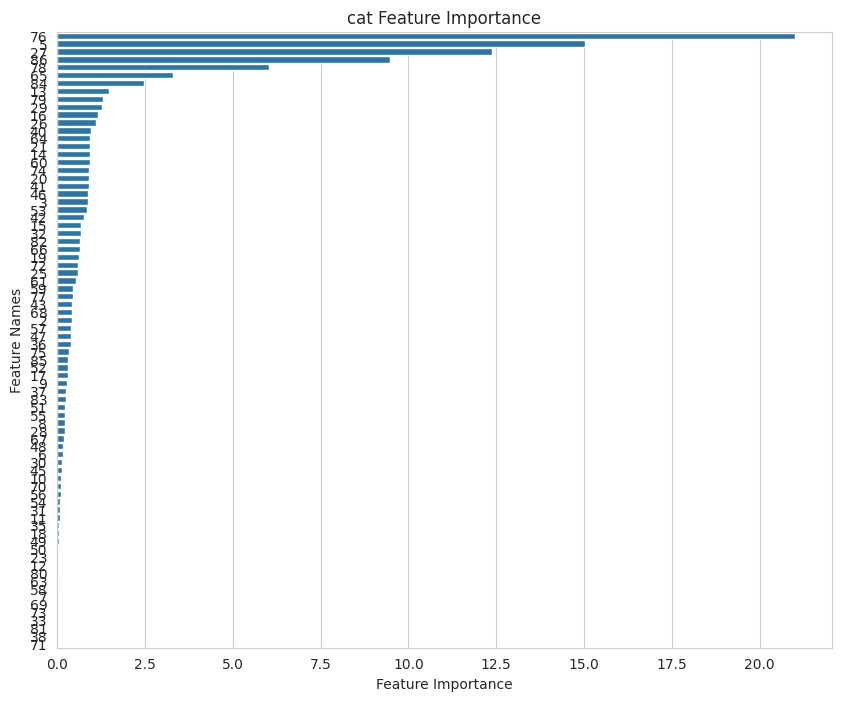

In [219]:
%%time
# https://catboost.ai/en/docs/concepts/speed-up-training

# this dataset is fairly small, so catboost runs super slow on GPU
# https://github.com/catboost/catboost/issues/1034


fold_num = 10

# convert datatype to integer -> use 'cat_features' parameter
# it does not improve score, feel free to try it out
# for c in cat_cols:
#     X[c] = X[c].astype(np.int)
#     X_test[c] = X_test[c].astype(np.int)

cat_params  = {
    'eval_metric':"AUC",
    'loss_function': 'logloss',
    'objective': 'Logloss',
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bayesian', 
    'colsample_bylevel': 0.013457968759952536, # does not support on gpu https://catboost.ai/en/docs/references/training-parameters/common#rsm
    'depth': 6,
    'iterations': 6888,
    'learning_rate': 0.05683590866750785,
    'random_strength': 18, 
    'l2_leaf_reg': 50,
    'random_state': SEED,
#     'task_type':"GPU",
#     'devices' : '0',
    # 'cat_features':cat_cols
    }


cat = CatBoostClassifier(**cat_params)

train_model(cat, 'cat', X, y, X_test, fold_num)

In [220]:
%%time
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=int(SEED), shuffle=True, stratify=y)
    
    # parameters
    params = {
        'iterations' : trial.suggest_int('iterations', 6000, 8000), 
        'depth' : trial.suggest_int('depth', 3, 12),
        'learning_rate' :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.01, 0.1), #  # does not support on gpu 
        'random_strength' :trial.suggest_int('random_strength', 0, 100),   
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]  # https://catboost.ai/en/docs/concepts/algorithm-main-stages_bootstrap-options
        ),
        'random_state': trial.suggest_categorical('random_state',[SEED]),
    }

    # learning
    model = CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="AUC",
        # task_type="GPU",
        l2_leaf_reg=50,
#         border_count=64,
        **params
    )        
    model.fit(X_train, y_train, 
              verbose=False) # 1000
    val_preds = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, val_preds) # AUROC requires probabilities of the predictions
    # print("AUC Score : ",auc) # check the auc score in each trial
    
    return auc

CPU times: user 34 µs, sys: 7 µs, total: 41 µs
Wall time: 95.8 µs


In [221]:
%%time
n_trials = int(150)

# set logging level
# optuna.logging.set_verbosity(optuna_verbosity)

study = optuna.create_study(direction = "maximize", sampler = optuna.samplers.TPESampler(seed=int(SEED)))
study.optimize(objective, n_trials = n_trials, n_jobs = multiprocessing.cpu_count())

printmd('**BEST TRIAL**')
print("Best Score: ", study.best_value)
printmd('**CatBoost Tuned Hyperparameters**')
pprint.pprint(study.best_trial.params)

**BEST TRIAL**

Best Score:  0.9036673491988879


**CatBoost Tuned Hyperparameters**

{'boosting_type': 'Ordered',
 'bootstrap_type': 'MVS',
 'colsample_bylevel': 0.09418952652664625,
 'depth': 4,
 'iterations': 6890,
 'learning_rate': 0.02106495292213335,
 'objective': 'Logloss',
 'random_state': 42,
 'random_strength': 75}
CPU times: user 8h 47min 42s, sys: 29min 6s, total: 9h 16min 48s
Wall time: 35min 55s


In [222]:
# Save
pickle.dump(study.best_trial.params, open('CatBoost_Hyperparameter.pickle', 'wb'))
print("Best Score: ", study.best_value)

printmd('**CatBoost Tuned Hyperparameters**')
pprint.pprint(study.best_trial.params)
#{'boosting_type': 'Ordered',
#  'bootstrap_type': 'MVS',
#  'colsample_bylevel': 0.09418952652664625,
#  'depth': 4,
#  'iterations': 6890,
#  'learning_rate': 0.02106495292213335,
#  'objective': 'Logloss',
#  'random_state': 42,
#  'random_strength': 75}

# history
display(optuna.visualization.plot_optimization_history(study))

# Importance
display(plot_param_importances(study))

Best Score:  0.9036673491988879


**CatBoost Tuned Hyperparameters**

{'boosting_type': 'Ordered',
 'bootstrap_type': 'MVS',
 'colsample_bylevel': 0.09418952652664625,
 'depth': 4,
 'iterations': 6890,
 'learning_rate': 0.02106495292213335,
 'objective': 'Logloss',
 'random_state': 42,
 'random_strength': 75}


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

**xgb Init**

--------------------------------------------------
Fold 1
AUC Score :  0.914583850931677
--------------------------------------------------
Fold 2
AUC Score :  0.9114534161490682
--------------------------------------------------
Fold 3
AUC Score :  0.9005704365079366
--------------------------------------------------
Fold 4
AUC Score :  0.905725
--------------------------------------------------
Fold 5
AUC Score :  0.8757250000000001
--------------------------------------------------
Fold 6
AUC Score :  0.8774
--------------------------------------------------
Fold 7
AUC Score :  0.8314999999999999
--------------------------------------------------
Fold 8
AUC Score :  0.8626
--------------------------------------------------
Fold 9
AUC Score :  0.923125
--------------------------------------------------
Fold 10
AUC Score :  0.8914000000000001
--------------------------------------------------
Train : Base Model - xgb - AUC score : mean ---> 0.8894082703588684, std ---> 0.0265610510981

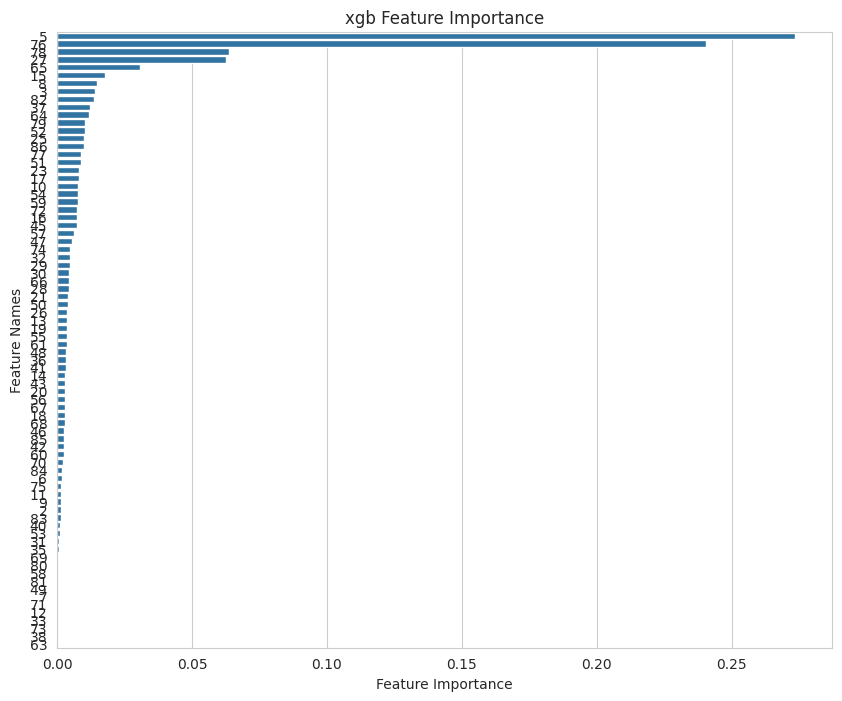

In [228]:
%%time
fold_num = 10


# https://stackoverflow.com/questions/51022822/subsample-colsample-bytree-colsample-bylevel-in-xgbclassifier-python-3-x

xgb_params = {'colsample_bytree': 0.2645340949128848,
'eval_metric': 'auc',
'tree_method': 'gpu_hist',
'gpu_id': 0,
'predictor': 'gpu_predictor',
'gamma': 0,
'learning_rate': 0.001851851953410451,
'max_depth': 3,
'n_estimators': 6000,
'random_state': SEED,
'reg_lambda': 0.1,
'subsample': 0.6905005604726816,
'use_label_encoder': False }


xgb = XGBClassifier(**xgb_params)

train_model(xgb, 'xgb', X, y, X_test, fold_num)

In [229]:
%%time
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=int(SEED), shuffle=True, stratify=y)

    params  = {
          'n_estimators': trial.suggest_categorical('n_estimators',[10000]),  
          'learning_rate': trial.suggest_float('learning_rate',1e-3,5e-1,log=True),
          'max_depth': trial.suggest_int('max_depth',3,12),
          'colsample_bytree': trial.suggest_float('colsample_bytree',0.2,0.99,log=True), 
          'subsample': trial.suggest_float('subsample',0.2,0.99,log=True),
          'eval_metric': trial.suggest_categorical('eval_metric',['auc']),
          'use_label_encoder':trial.suggest_categorical('use_label_encoder',[False]),
          'gamma': trial.suggest_categorical('gamma',[0, 0.25, 0.5, 1.0]),
          'reg_lambda': trial.suggest_categorical('reg_lambda',[0.1, 1.0, 5.0, 10.0, 50.0, 100.0]),
          'tree_method': trial.suggest_categorical('tree_method',['gpu_hist']),
          'gpu_id': trial.suggest_categorical('gpu_id',[0]),
          'predictor' : trial.suggest_categorical('predictor',['gpu_predictor']),
          'random_state': trial.suggest_categorical('random_state',[SEED])
         }

    # learning
    model = XGBClassifier(**params)        
    model.fit(X_train, y_train, 
              verbose=False) # 1000
    val_preds = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, val_preds) # AUROC requires probabilities of the predictions
    # print("AUC Score : ",auc) # check the auc score in each trial
    
    return auc

CPU times: user 10 µs, sys: 1 µs, total: 11 µs
Wall time: 15.3 µs


In [230]:
%%time
n_trials = int(150)

# set logging level
# optuna.logging.set_verbosity(optuna_verbosity)

study = optuna.create_study(direction = "maximize", sampler = optuna.samplers.TPESampler(seed=int(SEED)))
study.optimize(objective, n_trials = n_trials, n_jobs = multiprocessing.cpu_count())

printmd('**BEST TRIAL**')
print("Best Score: ", study.best_value)
printmd('**XGBoost Tuned Hyperparameters**')
pprint.pprint(study.best_trial.params)

[11:39:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:39:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

[11:39:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:39:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

[11:39:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:39:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU train

In [ ]:
# Save
pickle.dump(study.best_trial.params, open('XGB_Hyperparameter.pickle', 'wb'))
print("Best Score: ", study.best_value)

printmd('**XGBoost Tuned Hyperparameters**')
pprint.pprint(study.best_trial.params)


# history
display(optuna.visualization.plot_optimization_history(study))

# Importance
display(plot_param_importances(study))

In [ ]:
def stacking_data_loader(model, model_name, train, y, test, fold):
    '''
    input train, test datasets and fold value!
    returns train, test datasets for stacking ensemble
    '''

    stk = StratifiedKFold(n_splits = fold, random_state = SEED, shuffle = True)
    
    # Declaration Pred Datasets
    train_fold_pred = np.zeros((train.shape[0], 1))
    test_pred = np.zeros((test.shape[0], fold))
    
    for counter, (train_index, valid_index) in enumerate(stk.split(train, y)):
        X_train, y_train = train.iloc[train_index], y[train_index]
        X_valid, y_valid = train.iloc[valid_index], y[valid_index]

        print('------------ Fold', counter+1, 'Start! ------------')
        if model_name == 'cat':
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        elif model_name == 'xgb':
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose = False, early_stopping_rounds = 200)
        else:
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose = False, early_stopping_rounds = 200)
            
        print('------------ Fold', counter+1, 'Done! ------------')
        
        train_fold_pred[valid_index, :] = model.predict_proba(X_valid)[:, 1].reshape(-1, 1)
        test_pred[:, counter] = model.predict_proba(test)[:, 1]
        del X_train, y_train, X_valid, y_valid
        gc.collect()
        
    test_pred_mean = np.mean(test_pred, axis = 1).reshape(-1, 1)
    
    del test_pred
    gc.collect()
    
    print('Done!')
    
    return train_fold_pred, test_pred_mean

In [ ]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True, stratify=y)

lgbm_params = {'n_estimators': 12749, 
               'learning_rate': 0.1985328656822506, 
               'reg_alpha': 9.77289653841389, 
               'reg_lambda': 4.979048257991328, 
               'num_leaves': 921, 
               'min_child_samples': 85, 
               'max_depth': 56, 
               'colsample_bytree': 0.43848926369957975, 
               'cat_smooth': 92, 
               'cat_l2': 17, 
               'device': 'gpu',
               'gpu_platform_id': 0,
               'gpu_device_id': 0,
               'min_data_per_group': 59,
               'random_state': SEED,
              #  'is_unbalance':True,  # does not improve score
              # 'categorical_feature': cat_cols, # does not improve score
               }


lgbm = lgb.LGBMClassifier(**lgbm_params)


xgb_params = {'colsample_bytree': 0.2645340949128848,
            'eval_metric': 'auc',
            'tree_method': 'gpu_hist',
            'gpu_id': 0,
            'predictor': 'gpu_predictor',
            'gamma': 0,
            'learning_rate': 0.001851851953410451,
            'max_depth': 3,
            'n_estimators': 6000,
            'random_state': SEED,
            'reg_lambda': 0.1,
            'subsample': 0.6905005604726816,
            'use_label_encoder': False }

xgb = XGBClassifier(**xgb_params)


cat_params  = {'eval_metric':"AUC",
              #  'task_type':"GPU",
              'loss_function': 'logloss',
              'boosting_type': 'Plain',
              'bootstrap_type': 'Bayesian', # 0.846998114133664
              'colsample_bylevel': 0.013457968759952536,
              'depth': 6,
              'iterations': 6888,
              'learning_rate': 0.05683590866750785,
              'objective': 'Logloss',
              'random_strength': 18, 
              'l2_leaf_reg': 50,
              'random_state': SEED,
              # 'cat_features':cat_cols
              }


cat = CatBoostClassifier(**cat_params)

fold_num = 5

cat_train, cat_test = stacking_data_loader(cat, 'cat', X, y, test, fold_num)
del cat
gc.collect()

lgbm_train, lgbm_test = stacking_data_loader(lgbm, 'lgbm', X, y, test, fold_num)
del lgbm
gc.collect()

xgb_train, xgb_test = stacking_data_loader(xgb, 'xgb', X, y, X_test, fold_num)
del xgb
gc.collect()

In [ ]:
stack_X_train = np.concatenate((cat_train, lgbm_train, xgb_train), axis = 1)
stack_X_test = np.concatenate((cat_test, lgbm_test, xgb_test), axis = 1)

del cat_train, lgbm_train, xgb_train, cat_test, lgbm_test, xgb_test
gc.collect()

stack_X_train.shape, stack_X_test.shape

In [ ]:
# meta model : LogisticRegression
fold = 5
stk = StratifiedKFold(n_splits = fold, random_state = SEED, shuffle = False)
test_pred_log_reg = np.zeros((stack_X_test.shape[0], fold))
auc_scores = []

for counter, (train_index, valid_index)in enumerate(stk.split(stack_X_train, y)):
    X_train, y_train = stack_X_train[train_index], y[train_index]
    X_valid, y_valid = stack_X_train[valid_index], y[valid_index]

    #### to SMOTE sampling, not advised, low performance
    # sm = SMOTE(sampling_strategy='all', random_state=SEED)
    # X_train, y_train = sm.fit_resample(X_train, y_train)
    # X_valid, y_valid = sm.fit_resample(X_valid, y_valid)
    
    lr = LogisticRegression(n_jobs = -1, random_state = SEED, C = 0.3, max_iter = 10000)
    lr.fit(X_train, y_train)
    
    valid_pred_log_reg = lr.predict_proba(X_valid)[:, 1]
    test_pred_log_reg[:, counter] = lr.predict_proba(stack_X_test)[:, 1]

    auc = roc_auc_score(y_valid, valid_pred_log_reg)
    auc_scores.append(auc)

    print('Fold', counter+1 , 'AUC :', auc)
    fold += 1

test_pred_log_reg_mean = np.mean(test_pred_log_reg, axis = 1).reshape(-1, 1)

print(f'AUC score : mean ---> {np.mean(auc_scores)}, std ---> {np.std(auc_scores)}')

plt.boxplot(auc_scores, showmeans=True)

plt.show()

# AUC score : mean ---> 0.8495059939911511, std ---> 0.014576136833225574

In [ ]:
roc_auc_score_log_reg = roc_auc_score(y_test, test_pred_log_reg_mean)

printmd(f"AUC on the test dataset : **{roc_auc_score_log_reg}**")

In [2]:
params = {'loss_function': 'Logloss',
 'random_seed': 2405,
 'use_best_model': True,
 'silent': True,
 'one_hot_max_size': 2,
 'eval_metric': 'AUC',
 'boosting_type': 'Ordered',
 'n_estimators': 4000,
 'learning_rate': 0.40884349384515956,
 'colsample_bylevel': 0.7812859750199326,
 'bagging_temperature': 0.0,
 'random_strength': 76.81564986368521,
 'reg_lambda': 78.27935227582829,
 'scale_pos_weight': 16.0}

In [65]:
from catboost import CatBoostClassifier

# Initialize CatBoost classifier
#{'depth': 4, 'iterations': 300, 'learning_rate': 0.04})
# X = train.drop('Y', axis=1)
# y = train['Y']
# params = {'loss_function': 'Logloss',
#  'random_seed': 2405,
#  'use_best_model': True,
#  'silent': True,
#  'one_hot_max_size': 2,
#  'eval_metric': 'AUC',
#  'boosting_type': 'Ordered',
#  'n_estimators': 4000,
#  'learning_rate': 0.40884349384515956,
#  'colsample_bylevel': 0.7812859750199326,
#  'bagging_temperature': 0.0,
#  'random_strength': 76.81564986368521,
#  'reg_lambda': 78.27935227582829,
#  'scale_pos_weight': 16.0}
catboost_classifier = CatBoostClassifier()
# lgb_classifier = lgb.LGBMClassifier(objective='binary', metric='auc', n_estimators=100, random_state=42)
catboost_classifier.fit(X, y)

# Step 3: Generate predictions
y_test = catboost_classifier.predict_proba(test)[:, 1]
# acc=roc_auc_score(y_test, y_pred)
# print(acc)
# print(y_test[0])

# Step 4: Prepare the submission file
submission = pd.read_csv('data/rf1.csv')
submission.Y=y_test
submission.to_csv('submission.csv', index=False)

# Save the submission file
# submission.to_csv('lgbm_submission.csv', index=False)

# Since I can't execute the code, you can run these steps in your local environment to generate the submission file.

Learning rate set to 0.016119
0:	learn: 0.6826767	total: 1.88ms	remaining: 1.88s
1:	learn: 0.6721896	total: 3.93ms	remaining: 1.96s
2:	learn: 0.6623233	total: 5.94ms	remaining: 1.97s
3:	learn: 0.6522561	total: 8.88ms	remaining: 2.21s
4:	learn: 0.6431121	total: 12.5ms	remaining: 2.49s
5:	learn: 0.6338727	total: 15.8ms	remaining: 2.61s
6:	learn: 0.6249512	total: 18ms	remaining: 2.56s
7:	learn: 0.6166796	total: 19.9ms	remaining: 2.47s
8:	learn: 0.6086133	total: 22.2ms	remaining: 2.44s
9:	learn: 0.6015138	total: 24.3ms	remaining: 2.4s
10:	learn: 0.5942759	total: 26.8ms	remaining: 2.41s
11:	learn: 0.5871196	total: 30.3ms	remaining: 2.49s
12:	learn: 0.5802927	total: 33.6ms	remaining: 2.55s
13:	learn: 0.5739899	total: 36.2ms	remaining: 2.55s
14:	learn: 0.5676847	total: 38.4ms	remaining: 2.52s
15:	learn: 0.5623698	total: 40.6ms	remaining: 2.5s
16:	learn: 0.5562994	total: 43.6ms	remaining: 2.52s
17:	learn: 0.5505348	total: 46.4ms	remaining: 2.53s
18:	learn: 0.5453431	total: 48.9ms	remaining: 2.

In [781]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [1]:
params = {'loss_function': 'Logloss',
 'random_seed': 2405,
 'use_best_model': True,
 'silent': True,
 'one_hot_max_size': 2,
 'eval_metric': 'AUC',
 'boosting_type': 'Ordered',
 'n_estimators': 4000,
 'learning_rate': 0.40884349384515956,
 'colsample_bylevel': 0.7812859750199326,
 'bagging_temperature': 0.0,
 'random_strength': 76.81564986368521,
 'reg_lambda': 78.27935227582829,
 'scale_pos_weight': 16.0}

In [844]:
xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(score)

ValueError: Found input variables with inconsistent numbers of samples: [3854, 856]

In [830]:
model=XGBClassifier(learning_rate=0.2, n_estimators=2000, max_depth=4, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [832]:
y_pred = model.predict_proba(X_test)[:,1]
acc=roc_auc_score(y_test, y_pred)
print(acc)

ValueError: continuous format is not supported

In [795]:
y_test=model.predict_proba(x_test)[:,1]

In [796]:
submission = pd.read_csv('data/rf1.csv')
submission.Y=y_test
submission.to_csv('submission.csv', index=False)

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

# Define the Neural Network for Binary Classification
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(BinaryClassifier, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, 1)  # Only one output neuron for binary classification
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.layer3(x))  # Sigmoid activation for binary classification
        return x

# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim1 = 128
hidden_dim2 = 64
learning_rate = 0.001
num_epochs = 50
batch_size = 64

# Instantiate the model, loss, and optimizer
model = BinaryClassifier(input_dim, hidden_dim1, hidden_dim2)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    permutation = torch.randperm(X_train_tensor.size()[0])
    for i in range(0, X_train_tensor.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices].unsqueeze(1)
        
        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation loss
    val_outputs = model(X_val_tensor)
    val_loss = criterion(val_outputs, y_val_tensor.unsqueeze(1))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')


(2282, 85) (2282,)
Epoch [1/50], Train Loss: 0.5853, Validation Loss: 0.5051
Epoch [2/50], Train Loss: 0.3568, Validation Loss: 0.4101
Epoch [3/50], Train Loss: 0.3775, Validation Loss: 0.4077
Epoch [4/50], Train Loss: 0.3136, Validation Loss: 0.3997
Epoch [5/50], Train Loss: 0.4360, Validation Loss: 0.3943
Epoch [6/50], Train Loss: 0.2681, Validation Loss: 0.3914
Epoch [7/50], Train Loss: 0.3725, Validation Loss: 0.3884
Epoch [8/50], Train Loss: 0.4575, Validation Loss: 0.3898
Epoch [9/50], Train Loss: 0.4464, Validation Loss: 0.3857
Epoch [10/50], Train Loss: 0.3536, Validation Loss: 0.3904
Epoch [11/50], Train Loss: 0.4774, Validation Loss: 0.3937
Epoch [12/50], Train Loss: 0.2379, Validation Loss: 0.3844
Epoch [13/50], Train Loss: 0.3996, Validation Loss: 0.3876
Epoch [14/50], Train Loss: 0.3537, Validation Loss: 0.3850
Epoch [15/50], Train Loss: 0.5162, Validation Loss: 0.3900
Epoch [16/50], Train Loss: 0.2823, Validation Loss: 0.3854
Epoch [17/50], Train Loss: 0.3138, Validation 

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the training data
train_data = pd.read_csv('data/train_final.csv')
train_data.drop(columns=['Id'], inplace=True)
X_train = train_data.drop(columns=['Y'])
y_train = train_data['Y']

# Normalize the features and handle missing values
scaler = StandardScaler()
X_train = X_train.fillna(X_train.median())
X_train = scaler.fit_transform(X_train)

# Convert to PyTorch tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)


# Define the BinaryClassifier
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super(BinaryClassifier, self).__init__()
        
        # Ensure there are 10 hidden layers
        assert len(hidden_dims) == 10
        
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_dim, hidden_dims[0]))
        
        # Hidden layers
        for i in range(9):
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            
        # Output layer
        self.layers.append(nn.Linear(hidden_dims[-1], 1))
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        for i in range(10):  # 10 hidden layers
            x = self.relu(self.layers[i](x))
        x = self.sigmoid(self.layers[-1](x))  # Output layer
        return x


# Instantiate and train the model
input_dim = X_train.shape[1]
hidden_dims = [128, 128, 64, 64, 32, 32, 16, 16, 8, 8]
model = BinaryClassifier(input_dim, hidden_dims)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 4000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Load the test data
test_data = pd.read_csv('data/test_final.csv')
test_ids = test_data['Id']
test_data.drop(columns=['Id'], inplace=True)

# Normalize the test features and handle missing values
X_test = test_data.fillna(test_data.median())
X_test = scaler.transform(X_test)

# Convert to PyTorch tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Evaluate the model and get probabilities
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    probabilities = outputs.squeeze().numpy()

# Create a DataFrame and save to CSV
results_df = pd.DataFrame({
    'Id': test_ids,
    'Y': probabilities
})
results_df.to_csv('neural_network_test_outputs.csv', index=False)

Epoch [1/4000], Loss: 0.7098
Epoch [2/4000], Loss: 0.7093
Epoch [3/4000], Loss: 0.7088
Epoch [4/4000], Loss: 0.7083
Epoch [5/4000], Loss: 0.7078
Epoch [6/4000], Loss: 0.7073
Epoch [7/4000], Loss: 0.7068
Epoch [8/4000], Loss: 0.7063
Epoch [9/4000], Loss: 0.7058
Epoch [10/4000], Loss: 0.7053
Epoch [11/4000], Loss: 0.7048
Epoch [12/4000], Loss: 0.7043
Epoch [13/4000], Loss: 0.7038
Epoch [14/4000], Loss: 0.7033
Epoch [15/4000], Loss: 0.7029
Epoch [16/4000], Loss: 0.7024
Epoch [17/4000], Loss: 0.7019
Epoch [18/4000], Loss: 0.7014
Epoch [19/4000], Loss: 0.7009
Epoch [20/4000], Loss: 0.7004
Epoch [21/4000], Loss: 0.6998
Epoch [22/4000], Loss: 0.6992
Epoch [23/4000], Loss: 0.6985
Epoch [24/4000], Loss: 0.6977
Epoch [25/4000], Loss: 0.6969
Epoch [26/4000], Loss: 0.6958
Epoch [27/4000], Loss: 0.6946
Epoch [28/4000], Loss: 0.6932
Epoch [29/4000], Loss: 0.6914
Epoch [30/4000], Loss: 0.6893
Epoch [31/4000], Loss: 0.6867
Epoch [32/4000], Loss: 0.6837
Epoch [33/4000], Loss: 0.6800
Epoch [34/4000], Lo

In [28]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb

# Splitting the training data into features and target
X = train.drop(columns=['Y'])
y = train['Y']

# Setting up Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for out-of-fold predictions
oof_preds = np.zeros((X.shape[0], 2))  # We have 3 base models

# Training base models and collecting out-of-fold predictions
for train_idx, valid_idx in skf.split(X, y):
    # Splitting data into training and validation sets
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # CatBoost
    cat_model = CatBoostClassifier(eval_metric='AUC')
    cat_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=100, verbose=0)
    oof_preds[valid_idx, 0] = cat_model.predict_proba(X_valid)[:, 1]
    
    # XGBoost
    xgb_model = xgb.XGBClassifier(eval_metric='auc')
    xgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=0)
    oof_preds[valid_idx, 1] = xgb_model.predict_proba(X_valid)[:, 1]

# Training the meta-classifier logistic regression
log_model = LogisticRegression(solver='lbfgs')
log_model.fit(oof_preds, y)

#check accuracy
y_pred = log_model.predict(oof_preds)
score = accuracy_score(y, y_pred)
print(score)

# Making predictions on the test data
cat_test_preds = cat_model.predict_proba(test)[:, 1]
xgb_test_preds = xgb_model.predict_proba(test)[:, 1]

# Stacking the predictions
stacked_predictions = np.column_stack((cat_test_preds, xgb_test_preds))

# Making final predictions using the meta-classifier
final_predictions = log_model.predict_proba(stacked_predictions)[:, 1]

# Preparing the submission file
submission = pd.read_csv('data/rf1.csv')
submission.Y = final_predictions
submission.to_csv('stacking_submission.csv', index=False)



0.8352611286365229


In [35]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

# Sample data preparation (for illustration purposes)
# X, y = load_your_data()

X = train.drop(columns=['Y'])
y = train['Y']

# 1. Split the dataset into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train several CatBoost models on the training set.
# For simplicity, let's train 3 CatBoost models with different random seeds.
models = [CatBoostClassifier(iterations=500, learning_rate=0.05, random_seed=i, verbose=0) for i in range(3)]

for model in models:
    model.fit(X_train, y_train)

# 3. Use these trained CatBoost models to predict on the validation set.
predictions = [model.predict_proba(X_val)[:, 1] for model in models]

# Stacking predictions to create a new feature matrix
stacked_predictions = np.column_stack(predictions)

# 4. Use the predictions from step 3 as features to train a new CatBoost model.
final_model = CatBoostClassifier(iterations=500, learning_rate=0.05, verbose=0)
final_model.fit(stacked_predictions, y_val)

# 5. Evaluate the new model using the AUC score.
final_predictions = final_model.predict_proba(stacked_predictions)[:, 1]
auc_score = roc_auc_score(y_val, final_predictions)

print(f"AUC Score: {auc_score}")

# 6. Use the final model to make predictions on the test set.
test_predictions = [model.predict_proba(test)[:, 1] for model in models]
stacked_test_predictions = np.column_stack(test_predictions)
final_test_predictions = final_model.predict_proba(stacked_test_predictions)[:, 1]

# Preparing the submission file
submission = pd.read_csv('data/rf1.csv')
submission.Y = final_test_predictions
submission.to_csv('stacking_submission.csv', index=False)

AUC Score: 0.9988981573705179
